# Marketing Mix Modeling: Capstone 3 Project<br>

# EDA

## Table of Contents
* [A: Load Files](#a)
* [B: Explore Sales Data](#b)
* [C: Explore Media Investments](#c)
* [D: Merge Sales & Media Data](#d)
* [E: Explore Relationships](#e)
* [F: Next Steps](#f)

## A: Load Files <a class="anchor" id="a"></a>

In [78]:
#Import libraries
import pandas as pd
import numpy as np
import datetime
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patches as mpatches
import qgrid
def view(df_test):
    return qgrid.show_grid(df_test, grid_options={'forceFitColumns': False, 'defaultColumnWidth': 100})

from dateutil.relativedelta import relativedelta
import seaborn as sns
import statsmodels.api as sm  
from statsmodels.tsa.stattools import acf  
from statsmodels.tsa.stattools import pacf
from statsmodels.tsa.stattools import adfuller
import random
import itertools

In [2]:
#Open files

sales_df = pd.read_pickle('../b_Data/Sales.pkl')
media_df = pd.read_pickle('../b_Data/Media.pkl')

## B: Explore Sales Data <a class="anchor" id="b"></a>

### Sales Level

In [3]:
#Inspect
sales_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1578079 entries, 0 to 1578078
Data columns (total 9 columns):
 #   Column               Non-Null Count    Dtype         
---  ------               --------------    -----         
 0   Date                 1578079 non-null  datetime64[ns]
 1   Sales_name           1578079 non-null  object        
 2   units                1578079 non-null  int64         
 3   product_category     1578079 non-null  object        
 4   product_subcategory  1578079 non-null  object        
 5   product_vertical     1578079 non-null  object        
 6   revenue_USD          1578079 non-null  float64       
 7   mrp_USD              1578079 non-null  float64       
 8   discount_USD         1578079 non-null  float64       
dtypes: datetime64[ns](1), float64(3), int64(1), object(4)
memory usage: 108.4+ MB


In [4]:
#View data
sales_df.head()

,Date,Sales_name,units,product_category,product_subcategory,product_vertical,revenue_USD,mrp_USD,discount_USD
0,2015-07-01,No Promotion,1,EntertainmentSmall,HomeAudio,HomeAudioSpeaker,49.55,59.50,9.94
1,2015-07-01,No Promotion,1,EntertainmentSmall,Speaker,LaptopSpeaker,5.05,6.52,1.47
2,2015-07-01,No Promotion,1,GamingHardware,GamingAccessory,GamePad,32.58,130.38,97.80
3,2015-07-01,No Promotion,1,EntertainmentSmall,TVVideoSmall,RemoteControl,2.27,11.41,9.14
4,2015-07-01,No Promotion,1,EntertainmentSmall,TVVideoSmall,RemoteControl,1.61,11.41,9.80


Of variables available from sales df:
* Potential DV
    * units: number of sales
    * revenue_USD: sales revenue
* Potential Baseline variables (controls)
    * Price:
        * mrp_USD: maximum retail price
        * discount_USD: amount discounted
    * Product:
        * product_category
            * product_subcategory & product_vertical may be too granular for these purposes
* Potential Incremental variable (IV)
    * Sales_name: indicates when a promotion was used

In [5]:
#Review descriptives
sales_df.describe()

,units,revenue_USD,mrp_USD,discount_USD
count,1.578079e+06,1.578079e+06,1.578079e+06,1.578079e+06
mean,1.021809e+00,4.012449e+01,6.940196e+01,2.927810e+01
std,2.493014e-01,9.193246e+01,1.433372e+02,6.971163e+01
min,1.000000e+00,1.600000e-01,8.000000e-01,0.000000e+00
25%,1.000000e+00,5.530000e+00,1.304000e+01,5.050000e+00
50%,1.000000e+00,1.221000e+01,2.608000e+01,1.141000e+01
75%,1.000000e+00,3.257000e+01,5.703000e+01,2.525000e+01
max,5.000000e+01,3.699240e+03,6.846000e+03,6.819150e+03


### Create dummy variables for categorical variables:
While this is typically done in pre-processing, dummy variables will be necessary for creating aggregate dfs and exploring relationship between potential IV's and categorical variables

#### Promotions

In [6]:
#Create a promotions dummy variable
#Just going to use whether a promotion was present to minimize dimensions
sales_df['promotion'] = np.where((sales_df['Sales_name'] =='No Promotion'),0,1)
sales_df.head()

,Date,Sales_name,units,product_category,product_subcategory,product_vertical,revenue_USD,mrp_USD,discount_USD,promotion
0,2015-07-01,No Promotion,1,EntertainmentSmall,HomeAudio,HomeAudioSpeaker,49.55,59.50,9.94,0
1,2015-07-01,No Promotion,1,EntertainmentSmall,Speaker,LaptopSpeaker,5.05,6.52,1.47,0
2,2015-07-01,No Promotion,1,GamingHardware,GamingAccessory,GamePad,32.58,130.38,97.80,0
3,2015-07-01,No Promotion,1,EntertainmentSmall,TVVideoSmall,RemoteControl,2.27,11.41,9.14,0
4,2015-07-01,No Promotion,1,EntertainmentSmall,TVVideoSmall,RemoteControl,1.61,11.41,9.80,0


In [7]:
#See percentage of sales with promotion
sales_df['promotion'].value_counts(normalize=True)

0    0.818616
1    0.181384
Name: promotion, dtype: float64

#### Product Category

In [8]:
sales_df['product_category'].value_counts()

EntertainmentSmall    918775
CameraAccessory       246499
GamingHardware        222773
Camera                 99301
GameCDDVD              90731
Name: product_category, dtype: int64

In [9]:
#One hot-encode product category using pd.dummies
sales_df[['prod_cam','prod_cam_assry','prod_small_ent','prod_game_cddvd','prod_gaming_hw']] = pd.get_dummies(sales_df['product_category'])
#Check work
sales_df.head()

,Date,Sales_name,units,product_category,product_subcategory,product_vertical,revenue_USD,mrp_USD,discount_USD,promotion,prod_cam,prod_cam_assry,prod_small_ent,prod_game_cddvd,prod_gaming_hw
0,2015-07-01,No Promotion,1,EntertainmentSmall,HomeAudio,HomeAudioSpeaker,49.55,59.50,9.94,0,0,0,1,0,0
1,2015-07-01,No Promotion,1,EntertainmentSmall,Speaker,LaptopSpeaker,5.05,6.52,1.47,0,0,0,1,0,0
2,2015-07-01,No Promotion,1,GamingHardware,GamingAccessory,GamePad,32.58,130.38,97.80,0,0,0,0,0,1
3,2015-07-01,No Promotion,1,EntertainmentSmall,TVVideoSmall,RemoteControl,2.27,11.41,9.14,0,0,0,1,0,0
4,2015-07-01,No Promotion,1,EntertainmentSmall,TVVideoSmall,RemoteControl,1.61,11.41,9.80,0,0,0,1,0,0


#### Drop variables that will not be explored:
* Sales_name: categorical, dummy coded in promotion
* product_category: categorical, dummy coded
* product_subcategory: categorical, too granular
* product_vertical: categorical, too granular
* prod_game_cddvd: 5th product category (already accounted for in process of elimination of dummy variables)

In [10]:
#drop variables
sales_df = sales_df.drop(columns = ['Sales_name','product_category','product_subcategory','product_vertical','prod_game_cddvd'])
sales_df.head()

,Date,units,revenue_USD,mrp_USD,discount_USD,promotion,prod_cam,prod_cam_assry,prod_small_ent,prod_gaming_hw
0,2015-07-01,1,49.55,59.50,9.94,0,0,0,1,0
1,2015-07-01,1,5.05,6.52,1.47,0,0,0,1,0
2,2015-07-01,1,32.58,130.38,97.80,0,0,0,0,1
3,2015-07-01,1,2.27,11.41,9.14,0,0,0,1,0
4,2015-07-01,1,1.61,11.41,9.80,0,0,0,1,0


### Sales Level Distributions

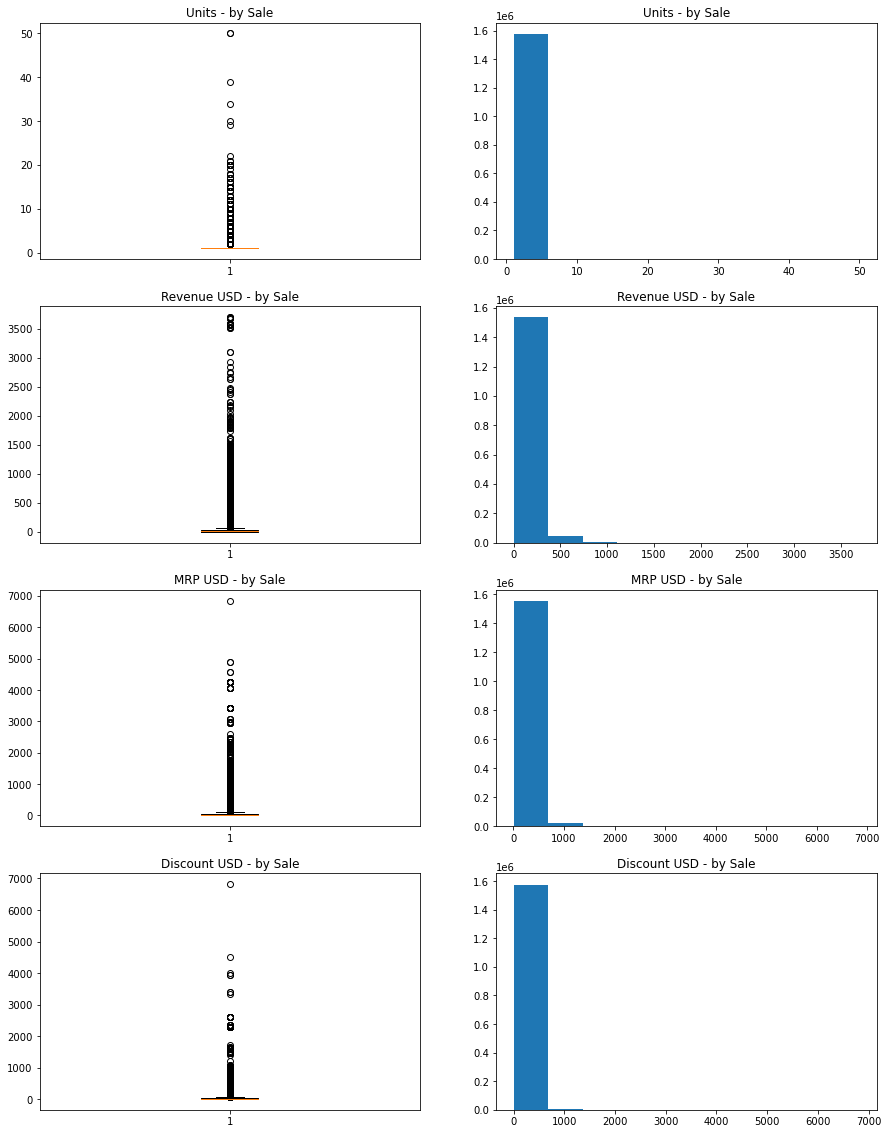

In [11]:
#View distribution box plot
plt.figure(figsize=(15,20))
plt.subplot(4,2,1)
plt.boxplot(sales_df['units'])
plt.title('Units - by Sale')

plt.subplot(4,2,2)
plt.hist(sales_df['units'])
plt.title('Units - by Sale')

plt.subplot(4,2,3)
plt.boxplot(sales_df['revenue_USD'])
plt.title('Revenue USD - by Sale')

plt.subplot(4,2,4)
plt.hist(sales_df['revenue_USD'])
plt.title('Revenue USD - by Sale')

plt.subplot(4,2,5)
plt.boxplot(sales_df['mrp_USD'])
plt.title('MRP USD - by Sale')

plt.subplot(4,2,6)
plt.hist(sales_df['mrp_USD'])
plt.title('MRP USD - by Sale')

plt.subplot(4,2,7)
plt.boxplot(sales_df['discount_USD'])
plt.title('Discount USD - by Sale')

plt.subplot(4,2,8)
plt.hist(sales_df['discount_USD'])
plt.title('Discount USD - by Sale')


plt.show()

It looks like there are too many outliers to view a distribution at the sales level.

### Time Series at Sales Level: IV's Only

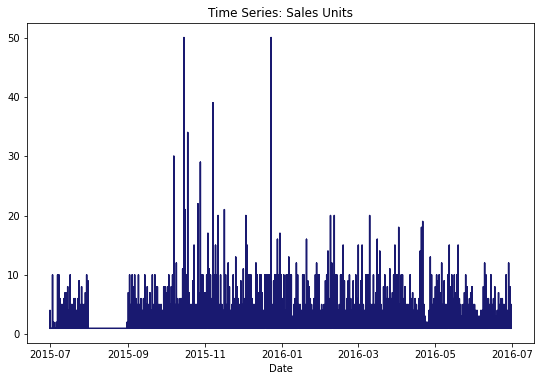

In [12]:
#Units

#Create plots
plt.figure(figsize=(20,20))
plt.subplot(3,2,1)
plt.plot(sales_df['Date'], sales_df['units'], color='midnightblue', label='Total')
plt.xlabel('Date')
plt.title('Time Series: Sales Units')
plt.show()

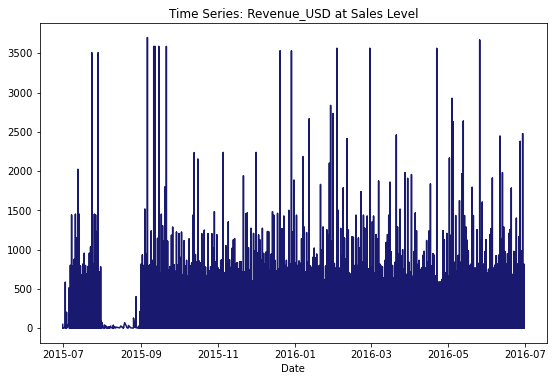

In [13]:
#Revenue

#Create plots
plt.figure(figsize=(20,20))
plt.subplot(3,2,1)
plt.plot(sales_df['Date'], sales_df['revenue_USD'], color='midnightblue', label='Total')
plt.xlabel('Date')
plt.title('Time Series: Revenue_USD at Sales Level')
plt.show()

There doesn't appear to be a trend over time, but there is a lot of variation. An aggregate time period might be more appropriate.

### Daily Level

In [14]:
#Aggregate at Daily level
daily_sales = sales_df.groupby(['Date']).sum().reset_index()
daily_sales.head()

,Date,units,revenue_USD,mrp_USD,discount_USD,promotion,prod_cam,prod_cam_assry,prod_small_ent,prod_gaming_hw
0,2015-07-01,29,332.43,769.98,437.56,0,0.0,1.0,20.0,3.0
1,2015-07-03,223,8475.08,14410.56,5935.53,0,8.0,29.0,141.0,22.0
2,2015-07-04,36,1327.14,1923.77,596.61,0,1.0,1.0,24.0,7.0
3,2015-07-05,1,30.95,48.88,17.93,0,0.0,0.0,1.0,0.0
4,2015-07-06,11,856.47,1200.93,344.47,0,1.0,0.0,6.0,3.0


In [15]:
#Inspect
daily_sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 360 entries, 0 to 359
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   Date            360 non-null    datetime64[ns]
 1   units           360 non-null    int64         
 2   revenue_USD     360 non-null    float64       
 3   mrp_USD         360 non-null    float64       
 4   discount_USD    360 non-null    float64       
 5   promotion       360 non-null    int64         
 6   prod_cam        360 non-null    float64       
 7   prod_cam_assry  360 non-null    float64       
 8   prod_small_ent  360 non-null    float64       
 9   prod_gaming_hw  360 non-null    float64       
dtypes: datetime64[ns](1), float64(7), int64(2)
memory usage: 28.2 KB


In [16]:
#Review descriptives
daily_sales.describe()

,units,revenue_USD,mrp_USD,discount_USD,promotion,prod_cam,prod_cam_assry,prod_small_ent,prod_gaming_hw
count,360.000000,3.600000e+02,3.600000e+02,3.600000e+02,360.000000,360.000000,360.000000,360.000000,360.000000
mean,4479.152778,1.758878e+05,3.042271e+05,1.283421e+05,795.108333,275.836111,684.719444,2552.152778,618.813889
std,3957.660070,1.858058e+05,3.515372e+05,1.675308e+05,3684.627844,397.702536,512.638575,2484.650323,466.829490
min,1.000000,6.480000e+00,9.780000e+00,1.800000e+00,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3403.250000,1.151323e+05,1.969813e+05,7.771055e+04,0.000000,164.750000,494.750000,1924.000000,483.250000
50%,4196.500000,1.534270e+05,2.591303e+05,1.052870e+05,0.000000,219.000000,629.500000,2272.000000,599.500000
75%,4896.250000,1.802500e+05,3.066115e+05,1.273265e+05,0.000000,273.250000,832.250000,2756.000000,716.000000
max,57574.000000,2.621143e+06,5.165483e+06,2.544348e+06,56492.000000,6156.000000,6177.000000,37215.000000,5550.000000


### Date Level Distributions

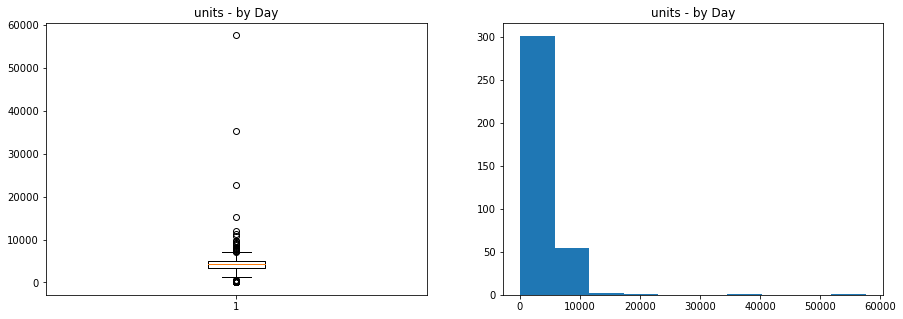

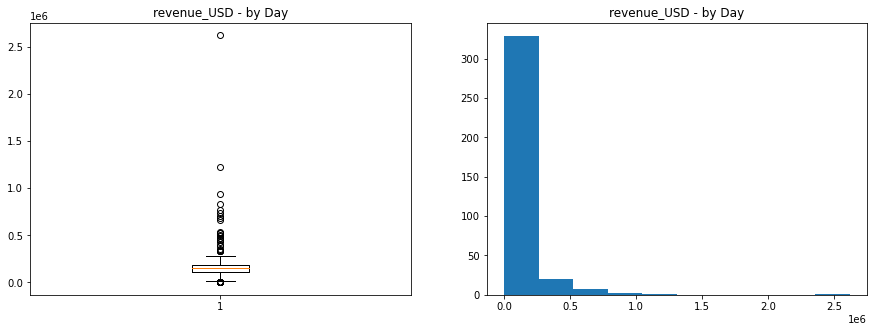

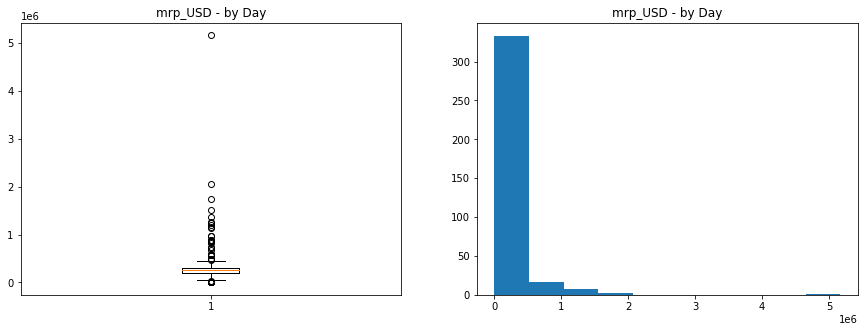

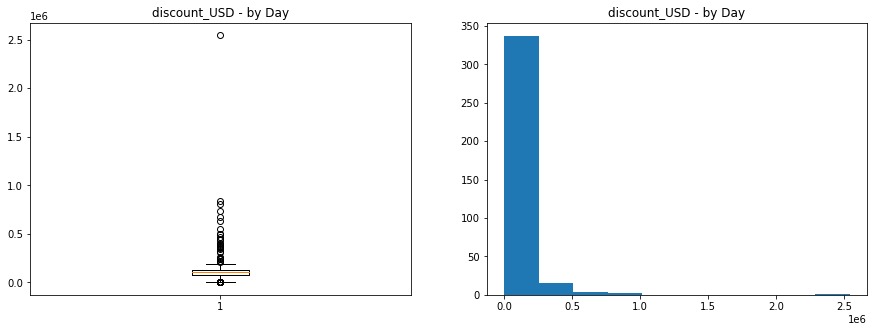

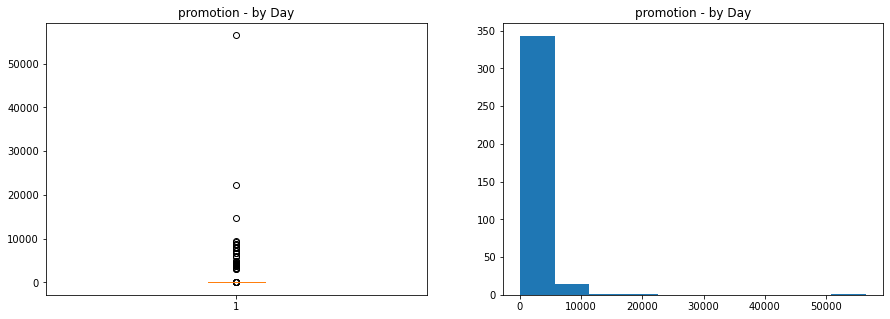

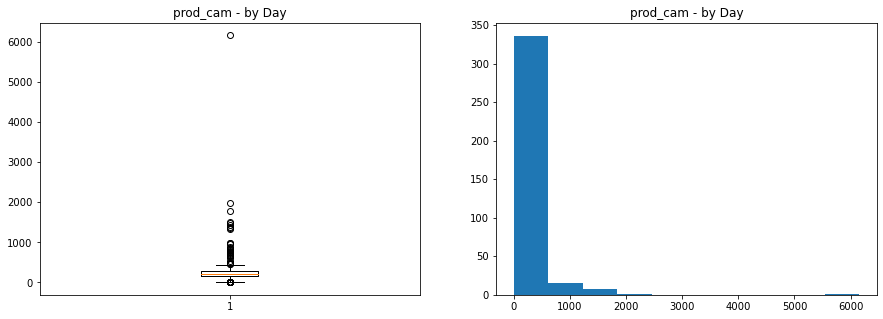

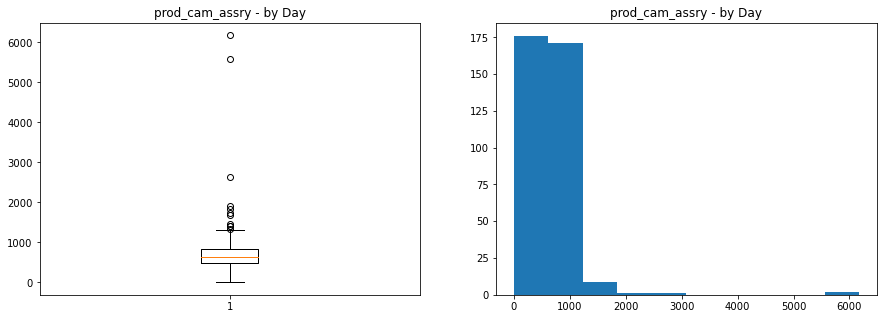

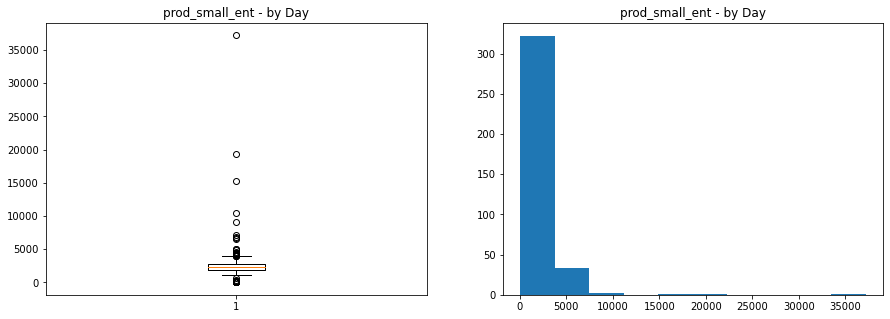

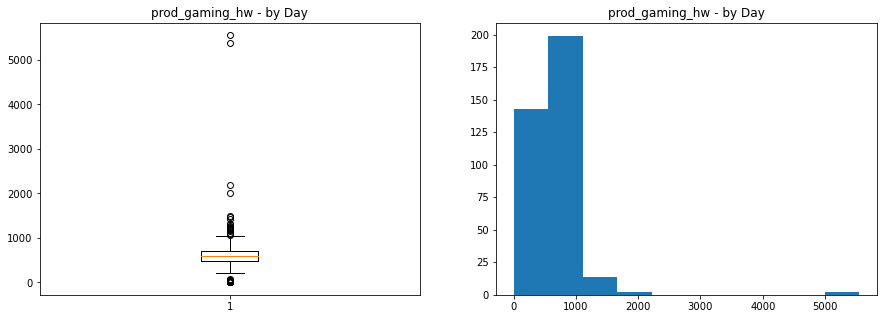

In [17]:
cols = ['units', 'revenue_USD', 'mrp_USD', 'discount_USD', 'promotion','prod_cam', 'prod_cam_assry', 'prod_small_ent', 'prod_gaming_hw']

def distribution_plots(df, col):
    plt.figure(figsize=(15,5))
    plt.subplot(1,2,1)
    plt.boxplot(df[col])
    plt.title(col + ' - by Day')
    
    plt.subplot(1,2,2)
    plt.hist(df[col])
    plt.title(col + ' - by Day')
    plt.show()
    
for col in cols:
    distribution_plots(daily_sales, col)

There are still a lot of outliers at the day level.

### Time Series at Day Level - IVs Only

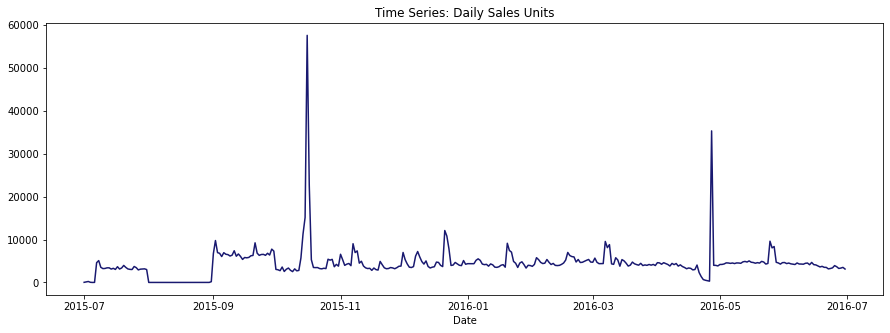

In [18]:
#Units

#Create plots
plt.figure(figsize=(15,5))
plt.plot(daily_sales['Date'], daily_sales['units'], color='midnightblue', label='Total')
plt.xlabel('Date')
plt.title('Time Series: Daily Sales Units')
plt.show()

At first glance it appears that there is a slight upwrad trend and two very large outliers around November and May. These could be due to holidays or promotions.

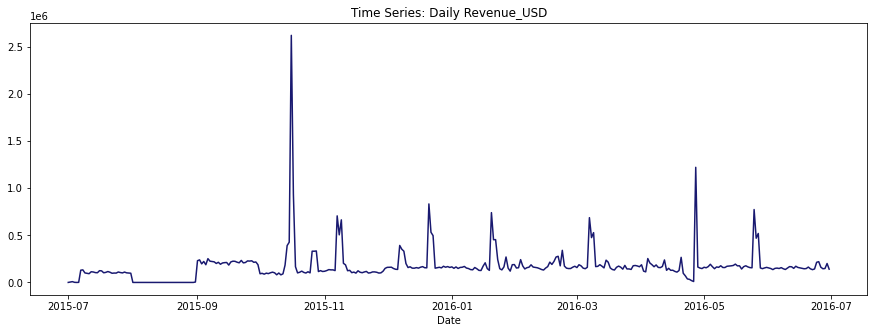

In [19]:
#Revenue

#Create plots
plt.figure(figsize=(15,5))
plt.plot(daily_sales['Date'], daily_sales['revenue_USD'], color='midnightblue', label='Total')
plt.xlabel('Date')
plt.title('Time Series: Daily Revenue_USD')
plt.show()

Similar trend as with units, but there appear to be a few more outliers. This may be due to macroeconomic factors or promotions that have a stronger impact on revenue than on units sold.

### Check if the data is stationary over time (independent of time)
[Dickey Fuller Test Function Adapted from Source]('https://github.com/seanabu/seanabu.github.io/blob/master/Seasonal_ARIMA_model_Portland_transit.ipynb')

In [20]:
#Dickey Fuller Test Function
def test_stationarity(timeseries):

    #Determing rolling statistics
    rolmean = pd.Series(timeseries).rolling(window=28).mean()
    rolstd = pd.Series(timeseries).rolling(window=28).std()

    #Plot rolling statistics:
    fig = plt.figure(figsize=(15, 5))
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    
    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput) 

In [21]:
#Index daily sales by date to use as Time Series
daily_sales['index'] = daily_sales['Date']
daily_sales.set_index(['index'], inplace=True)
daily_sales.index.name=None

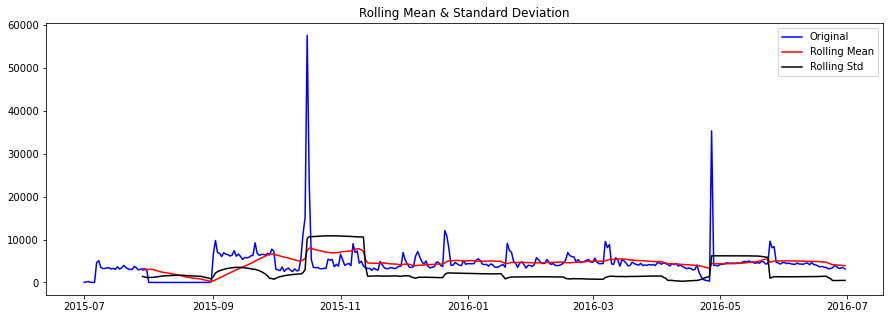

Results of Dickey-Fuller Test:
Test Statistic                -1.156503e+01
p-value                        3.201717e-21
#Lags Used                     0.000000e+00
Number of Observations Used    3.590000e+02
Critical Value (1%)           -3.448697e+00
Critical Value (5%)           -2.869625e+00
Critical Value (10%)          -2.571077e+00
dtype: float64


In [22]:
#Apply the Dickey Fuller test function to units
test_stationarity(daily_sales['units'])

According to the Dickey Fuller test (based on monthly (28 days) rolling mean and std), the daily unit sales data can be considered stationary. Therefore, we don't have to account for trends or seasonality in our model.
* Evaluation of Dickey Fuller Test:
    * Null Hypothesis: The data is not stationary over time
    * If p-value < .05 and Test Statistic < Critical Values, reject the null

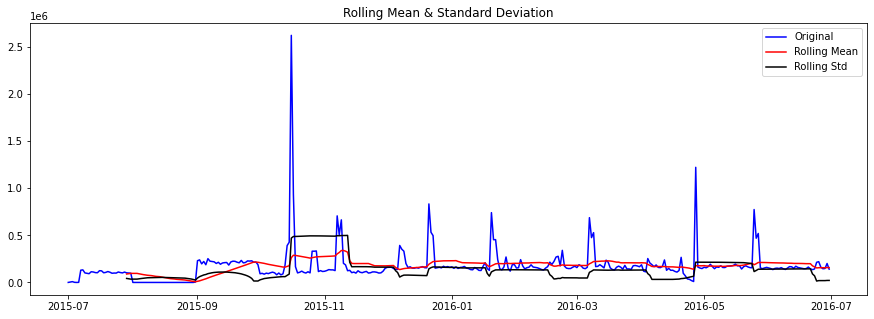

Results of Dickey-Fuller Test:
Test Statistic                -1.208235e+01
p-value                        2.217287e-22
#Lags Used                     0.000000e+00
Number of Observations Used    3.590000e+02
Critical Value (1%)           -3.448697e+00
Critical Value (5%)           -2.869625e+00
Critical Value (10%)          -2.571077e+00
dtype: float64


In [23]:
#Apply the Dickey Fuller test function to revenue
test_stationarity(daily_sales['revenue_USD'])

According to the Dickey Fuller test (based on monthly rolling mean and std), the daily revenue data can also be considered to be stationary.

### Rolling 3-Day Window Level
Although the daily sales data appears to be stationary over time (based on monthly rolling average and standard deviation), there were still a lot of outliers that could impact the final model. To address this, transform the daily_sales data to rolling 3-day average window.

In [24]:
#View daily sales again to compare to 3 day rolling averages
daily_sales.head()

,Date,units,revenue_USD,mrp_USD,discount_USD,promotion,prod_cam,prod_cam_assry,prod_small_ent,prod_gaming_hw
2015-07-01,2015-07-01,29,332.43,769.98,437.56,0,0.0,1.0,20.0,3.0
2015-07-03,2015-07-03,223,8475.08,14410.56,5935.53,0,8.0,29.0,141.0,22.0
2015-07-04,2015-07-04,36,1327.14,1923.77,596.61,0,1.0,1.0,24.0,7.0
2015-07-05,2015-07-05,1,30.95,48.88,17.93,0,0.0,0.0,1.0,0.0
2015-07-06,2015-07-06,11,856.47,1200.93,344.47,0,1.0,0.0,6.0,3.0


In [25]:
daily_sales_3day = daily_sales.copy()
cols = daily_sales_3day.columns.drop('Date').tolist()
cols

['units',
 'revenue_USD',
 'mrp_USD',
 'discount_USD',
 'promotion',
 'prod_cam',
 'prod_cam_assry',
 'prod_small_ent',
 'prod_gaming_hw']

In [26]:
#Create df replacing daily values for each variable with 3-day rolling averages
daily_sales_3day = daily_sales.copy()
cols = daily_sales_3day.columns.drop('Date').tolist()


for i in cols:
    daily_sales_3day[i] = pd.Series(daily_sales[i]).rolling(window=3).mean()

daily_sales_3day = daily_sales_3day.dropna()
daily_sales_3day

,Date,units,revenue_USD,mrp_USD,discount_USD,promotion,prod_cam,prod_cam_assry,prod_small_ent,prod_gaming_hw
2015-07-04,2015-07-04,96.000000,3378.216667,5701.436667,2323.233333,0.0,3.000000,10.333333,61.666667,10.666667
2015-07-05,2015-07-05,86.666667,3277.723333,5461.070000,2183.356667,0.0,3.000000,10.000000,55.333333,9.666667
2015-07-06,2015-07-06,16.000000,738.186667,1057.860000,319.670000,0.0,0.666667,0.333333,10.333333,3.333333
2015-07-07,2015-07-07,1541.333333,43652.226667,74333.196667,30680.616667,0.0,53.333333,173.666667,899.666667,325.333333
2015-07-08,2015-07-08,3238.666667,88125.926667,149918.863333,61793.006667,0.0,106.000000,387.333333,1999.666667,543.000000
...,...,...,...,...,...,...,...,...,...,...
2016-06-26,2016-06-26,3663.333333,198765.256667,320951.306667,122188.636667,0.0,307.666667,469.333333,1957.000000,499.666667
2016-06-27,2016-06-27,3616.333333,175870.700000,284722.433333,108854.276667,0.0,264.333333,469.333333,1944.333333,503.666667
2016-06-28,2016-06-28,3425.000000,151704.340000,243799.010000,92096.996667,0.0,203.000000,514.000000,1849.666667,489.000000
2016-06-29,2016-06-29,3373.000000,164710.600000,265737.436667,101029.186667,0.0,233.000000,530.000000,1796.333333,490.666667


In [27]:
#View descriptives for df with 3-day rolling averages

daily_sales_3day.describe()

,units,revenue_USD,mrp_USD,discount_USD,promotion,prod_cam,prod_cam_assry,prod_small_ent,prod_gaming_hw
count,358.000000,3.580000e+02,3.580000e+02,3.580000e+02,358.000000,358.000000,358.000000,358.000000,358.000000
mean,4494.824022,1.764122e+05,3.051948e+05,1.287854e+05,799.550279,276.770950,687.137803,2561.342644,620.854749
std,3037.374174,1.401095e+05,2.683080e+05,1.294650e+05,2879.634258,287.501767,378.599457,1943.410170,353.380070
min,1.666667,1.242333e+01,5.556667e+01,2.129333e+01,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3404.000000,1.185825e+05,1.984153e+05,8.344893e+04,0.000000,176.500000,509.333333,1990.083333,498.666667
50%,4328.333333,1.583374e+05,2.675329e+05,1.082490e+05,0.000000,225.333333,661.500000,2357.500000,601.000000
75%,4942.500000,1.876653e+05,3.198672e+05,1.323862e+05,0.000000,287.333333,863.083333,2814.250000,742.583333
max,31787.000000,1.327826e+06,2.689636e+06,1.361817e+06,31139.000000,2851.000000,2906.666667,20986.000000,3249.666667


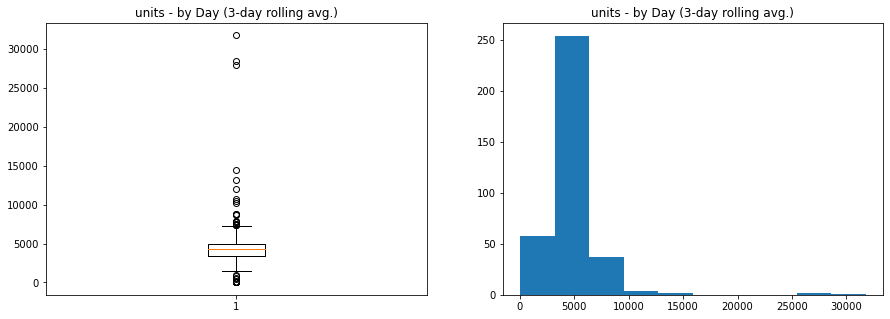

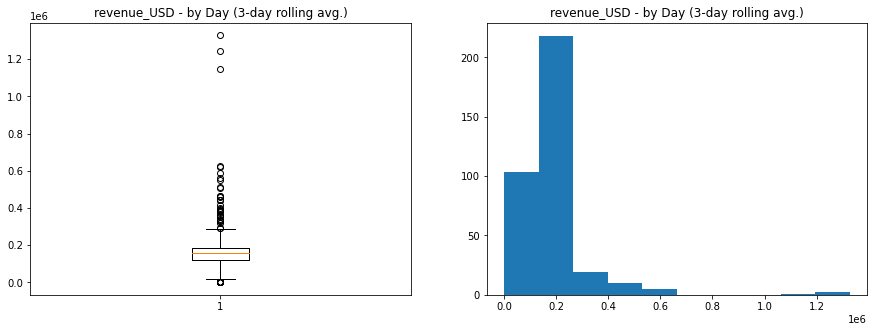

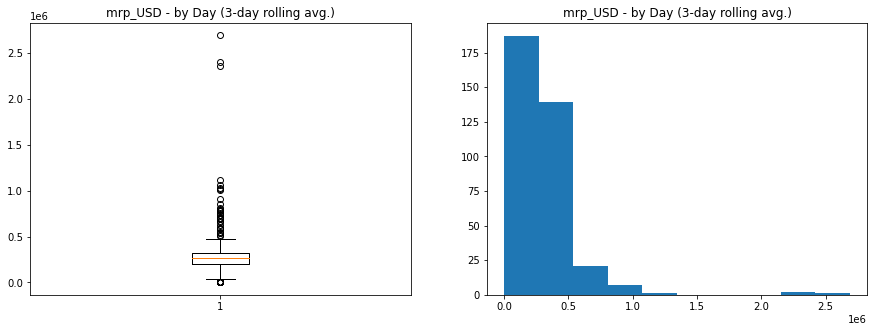

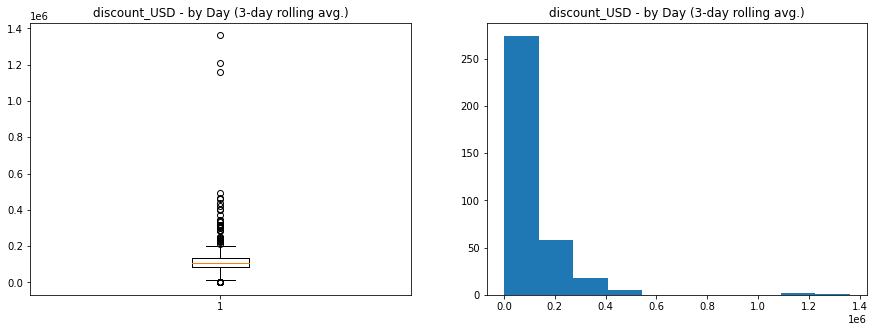

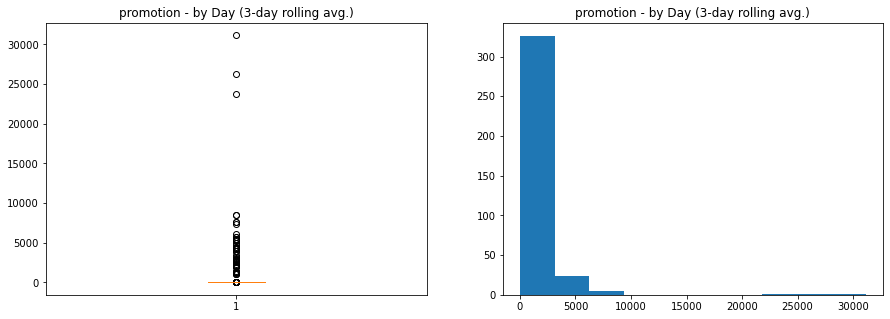

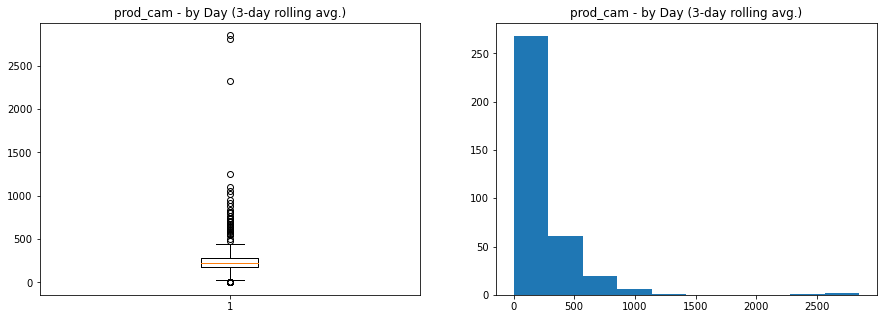

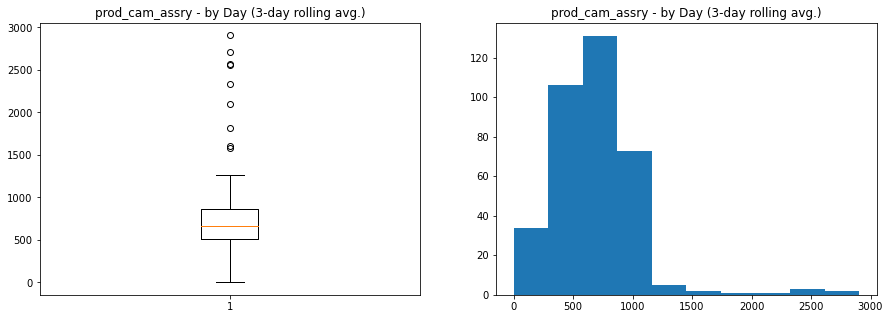

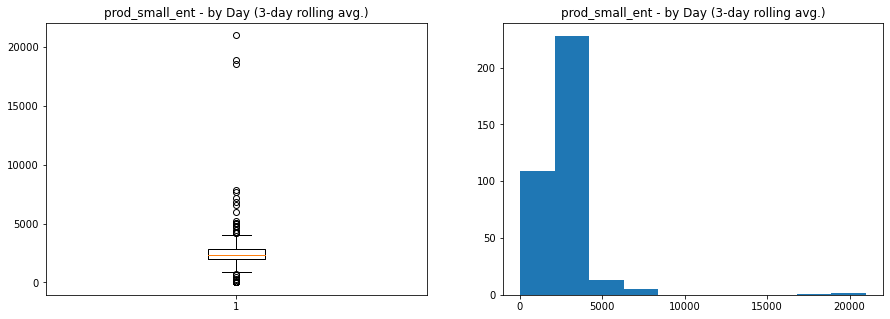

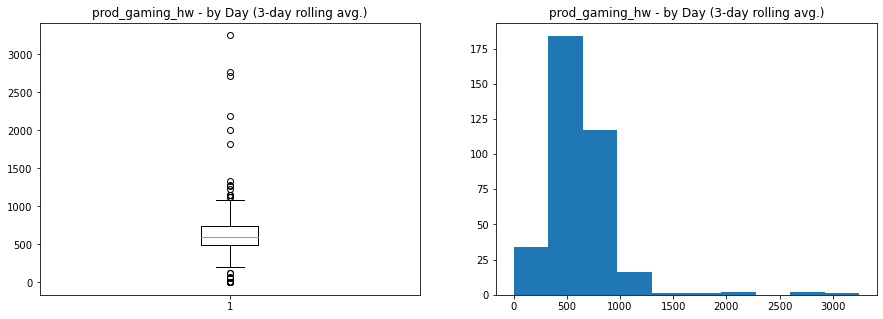

In [28]:
cols = ['units', 'revenue_USD', 'mrp_USD', 'discount_USD', 'promotion','prod_cam', 'prod_cam_assry', 'prod_small_ent', 'prod_gaming_hw']

def distribution_plots(df, col):
    plt.figure(figsize=(15,5))
    plt.subplot(1,2,1)
    plt.boxplot(df[col])
    plt.title(col + ' - by Day (3-day rolling avg.)')
    
    plt.subplot(1,2,2)
    plt.hist(df[col])
    plt.title(col + ' - by Day (3-day rolling avg.)')
    plt.show()
    
for col in cols:
    distribution_plots(daily_sales_3day, col)

While there are still some outliers, the distributions are now a little more clear.

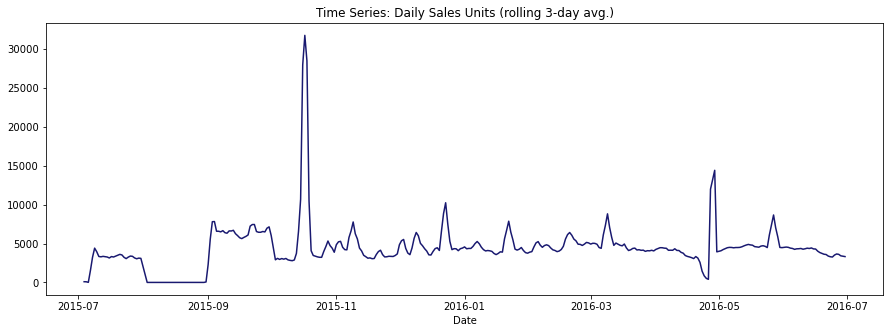

In [29]:
#Create plots
plt.figure(figsize=(15,5))
plt.plot(daily_sales_3day['Date'], daily_sales_3day['units'], color='midnightblue', label='Total')
plt.xlabel('Date')
plt.title('Time Series: Daily Sales Units (rolling 3-day avg.)')
plt.show()

The time series is now a lot smoother.

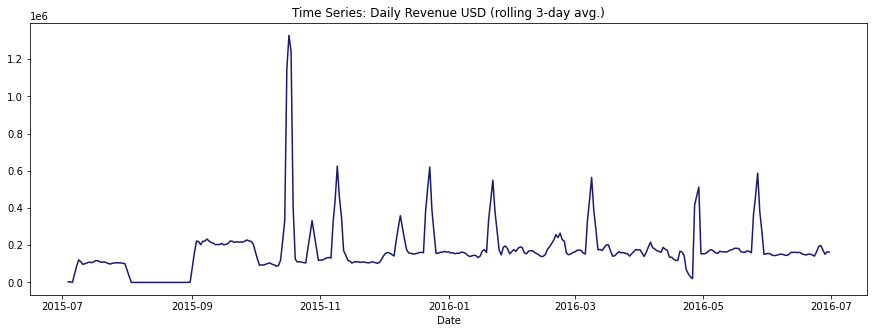

In [30]:
#Create plots
plt.figure(figsize=(15,5))
plt.plot(daily_sales_3day['Date'], daily_sales_3day['revenue_USD'], color='midnightblue', label='Total')
plt.xlabel('Date')
plt.title('Time Series: Daily Revenue USD (rolling 3-day avg.)')
plt.show()

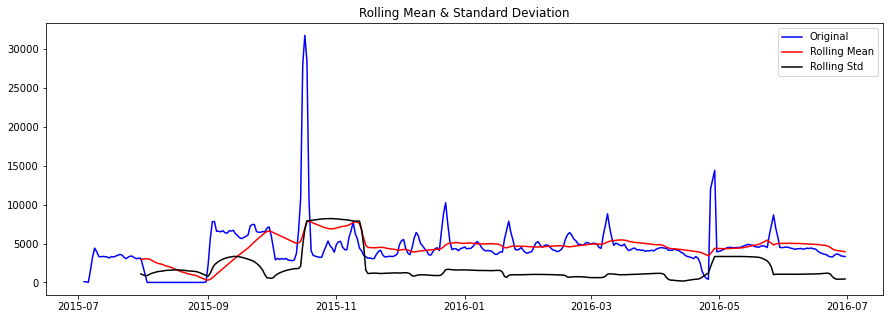

Results of Dickey-Fuller Test:
Test Statistic                  -3.777941
p-value                          0.003141
#Lags Used                      12.000000
Number of Observations Used    345.000000
Critical Value (1%)             -3.449447
Critical Value (5%)             -2.869954
Critical Value (10%)            -2.571253
dtype: float64


In [31]:
#Run Dickey Fuller Test again on data with 3-day rolling averages
test_stationarity(daily_sales_3day['units'])

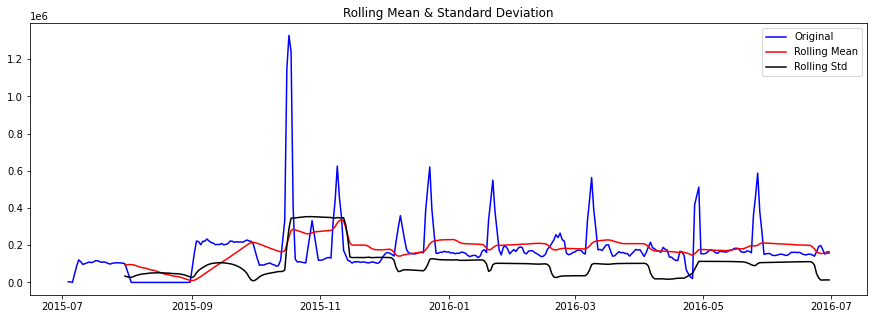

Results of Dickey-Fuller Test:
Test Statistic                  -3.909098
p-value                          0.001969
#Lags Used                      16.000000
Number of Observations Used    341.000000
Critical Value (1%)             -3.449673
Critical Value (5%)             -2.870053
Critical Value (10%)            -2.571306
dtype: float64


In [32]:
#Run Dickey Fuller Test again on data with 3-day rolling averages
test_stationarity(daily_sales_3day['revenue_USD'])

According to the Dickey Fuller Test, the data can still be considered stationary even with the 3day rolling averages used.

## C. Explore Media Spend <a class="anchor" id="c"></a>

In [33]:
#Inspect
media_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12 entries, 0 to 11
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   Year                   12 non-null     int64         
 1   Month                  12 non-null     int64         
 2   Total_Investment_USD   12 non-null     float64       
 3   TV_USD                 12 non-null     float64       
 4   Digital_USD            12 non-null     float64       
 5   Sponsorship_USD        12 non-null     float64       
 6   Content_Marketing_USD  12 non-null     float64       
 7   Online_Marketing_USD   12 non-null     float64       
 8   Affiliates_USD         12 non-null     float64       
 9   SEM_USD                12 non-null     float64       
 10  Radio_USD              12 non-null     float64       
 11  Other_USD              12 non-null     float64       
 12  Day                    12 non-null     int64         
 13  Date   

In [34]:
#View df
media_df.head()

,Year,Month,Total_Investment_USD,TV_USD,Digital_USD,Sponsorship_USD,Content_Marketing_USD,Online_Marketing_USD,Affiliates_USD,SEM_USD,Radio_USD,Other_USD,Day,Date
0,2015,7,278730.0,3260.0,40750.0,120620.0,0.0,21190.0,8150.0,81500.0,0.0,0.0,1,2015-07-01
1,2015,8,83130.0,0.0,21190.0,17930.0,0.0,1630.0,1630.0,40750.0,0.0,0.0,1,2015-08-01
2,2015,9,1569690.0,63570.0,22820.0,1023640.0,9780.0,267320.0,81500.0,101060.0,0.0,0.0,1,2015-09-01
3,2015,10,2774260.0,99430.0,205380.0,1380610.0,55420.0,397720.0,114100.0,519970.0,0.0,0.0,1,2015-10-01
4,2015,11,834560.0,68460.0,21190.0,231460.0,3260.0,319480.0,107580.0,84760.0,0.0,0.0,1,2015-11-01


In [35]:
#Create datetime month_year variable

#Create Month_Year column for labels
media_df['Month_Year'] = media_df['Date'].dt.strftime('%Y-%m')
media_df.head()

,Year,Month,Total_Investment_USD,TV_USD,Digital_USD,Sponsorship_USD,Content_Marketing_USD,Online_Marketing_USD,Affiliates_USD,SEM_USD,Radio_USD,Other_USD,Day,Date,Month_Year
0,2015,7,278730.0,3260.0,40750.0,120620.0,0.0,21190.0,8150.0,81500.0,0.0,0.0,1,2015-07-01,2015-07
1,2015,8,83130.0,0.0,21190.0,17930.0,0.0,1630.0,1630.0,40750.0,0.0,0.0,1,2015-08-01,2015-08
2,2015,9,1569690.0,63570.0,22820.0,1023640.0,9780.0,267320.0,81500.0,101060.0,0.0,0.0,1,2015-09-01,2015-09
3,2015,10,2774260.0,99430.0,205380.0,1380610.0,55420.0,397720.0,114100.0,519970.0,0.0,0.0,1,2015-10-01,2015-10
4,2015,11,834560.0,68460.0,21190.0,231460.0,3260.0,319480.0,107580.0,84760.0,0.0,0.0,1,2015-11-01,2015-11


In [36]:
#Drop additional date variables
media_df = media_df.drop(columns = ['Year','Month','Day'])
media_df.head()

,Total_Investment_USD,TV_USD,Digital_USD,Sponsorship_USD,Content_Marketing_USD,Online_Marketing_USD,Affiliates_USD,SEM_USD,Radio_USD,Other_USD,Date,Month_Year
0,278730.0,3260.0,40750.0,120620.0,0.0,21190.0,8150.0,81500.0,0.0,0.0,2015-07-01,2015-07
1,83130.0,0.0,21190.0,17930.0,0.0,1630.0,1630.0,40750.0,0.0,0.0,2015-08-01,2015-08
2,1569690.0,63570.0,22820.0,1023640.0,9780.0,267320.0,81500.0,101060.0,0.0,0.0,2015-09-01,2015-09
3,2774260.0,99430.0,205380.0,1380610.0,55420.0,397720.0,114100.0,519970.0,0.0,0.0,2015-10-01,2015-10
4,834560.0,68460.0,21190.0,231460.0,3260.0,319480.0,107580.0,84760.0,0.0,0.0,2015-11-01,2015-11


In [37]:
#Means for values of media_df sorted
round(media_df.mean(),2).sort_values()

Radio_USD                   6384.17
Content_Marketing_USD      10866.67
Digital_USD                40478.33
TV_USD                     60310.00
Other_USD                  65200.00
Affiliates_USD             83401.67
SEM_USD                   123744.17
Online_Marketing_USD      263109.17
Sponsorship_USD           496335.00
Total_Investment_USD     1149965.00
dtype: float64

In [38]:
#View descriptives
media_df.describe() 

,Total_Investment_USD,TV_USD,Digital_USD,Sponsorship_USD,Content_Marketing_USD,Online_Marketing_USD,Affiliates_USD,SEM_USD,Radio_USD,Other_USD
count,1.200000e+01,12.000000,12.000000,1.200000e+01,12.000000,12.000000,12.000000,12.000000,12.000000,12.000000
mean,1.149965e+06,60310.000000,40478.333333,4.963350e+05,10866.666667,263109.166667,83401.666667,123744.166667,6384.166667,65200.000000
std,7.258999e+05,43814.735172,53304.345692,4.275865e+05,15390.473047,137847.332711,41677.919996,129639.197738,13431.587233,140752.604303
min,8.313000e+04,0.000000,8150.000000,1.793000e+04,0.000000,1630.000000,1630.000000,40750.000000,0.000000,0.000000
25%,7.624325e+05,26487.500000,19560.000000,1.731875e+05,0.000000,233090.000000,72535.000000,68460.000000,0.000000,0.000000
50%,1.067650e+06,66015.000000,22820.000000,4.017950e+05,8150.000000,309700.000000,103505.000000,83130.000000,0.000000,0.000000
75%,1.584768e+06,85575.000000,35860.000000,7.396125e+05,13447.500000,368380.000000,110840.000000,103912.500000,3667.500000,20375.000000
max,2.774260e+06,151590.000000,205380.000000,1.380610e+06,55420.000000,397720.000000,120620.000000,519970.000000,44010.000000,441730.000000


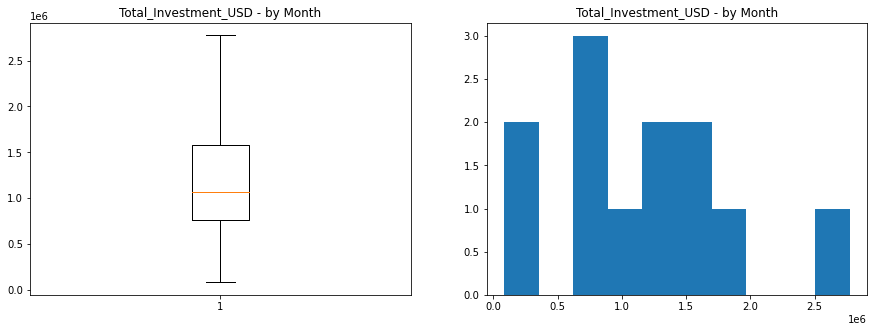

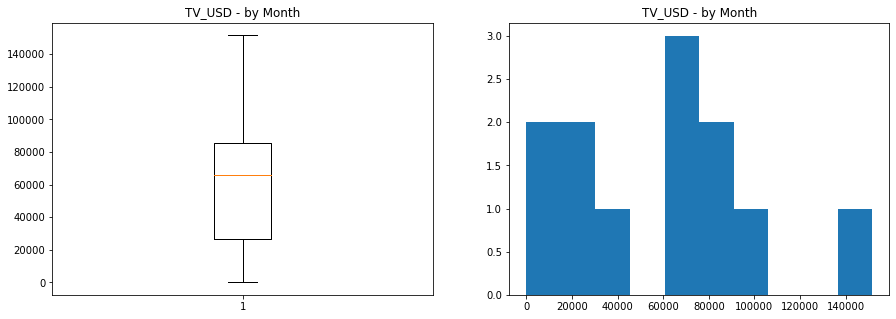

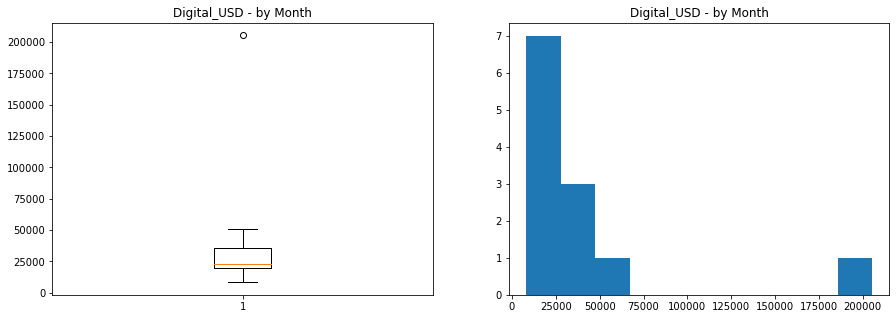

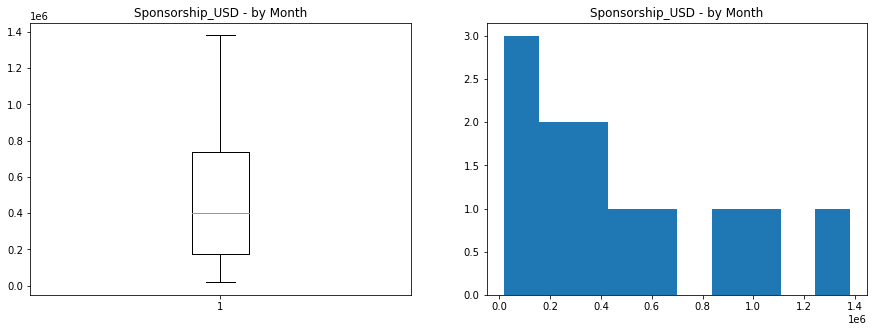

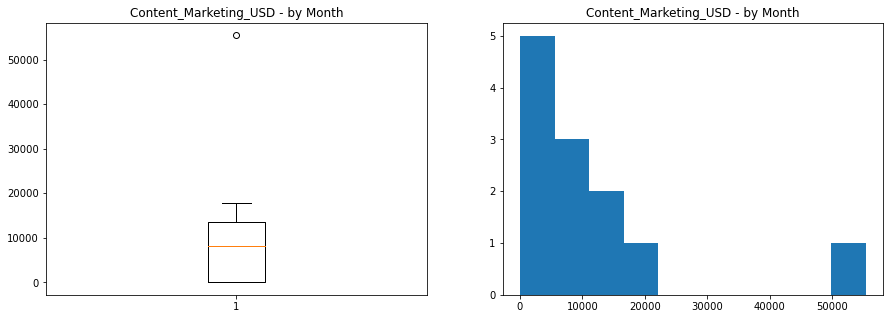

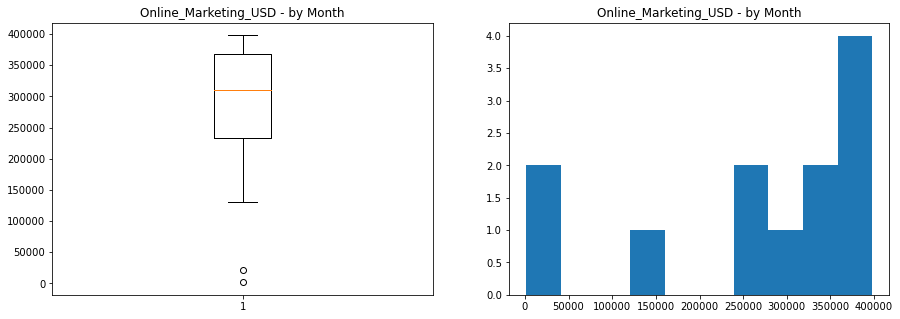

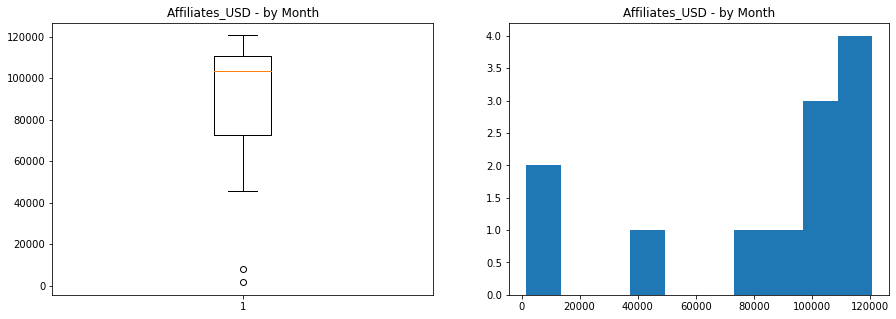

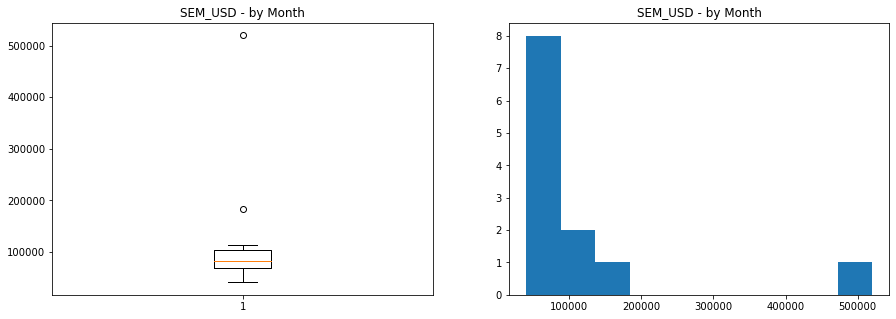

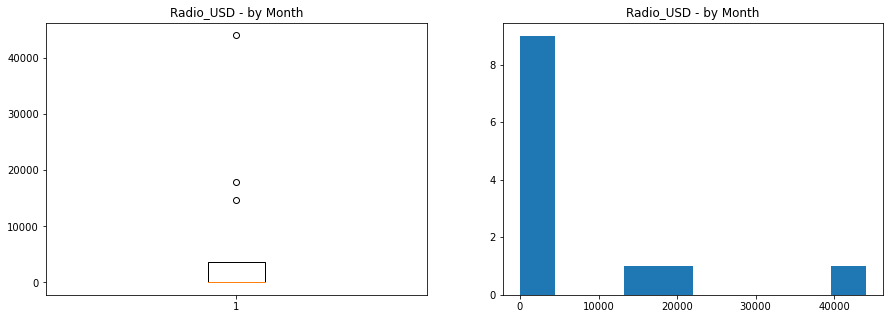

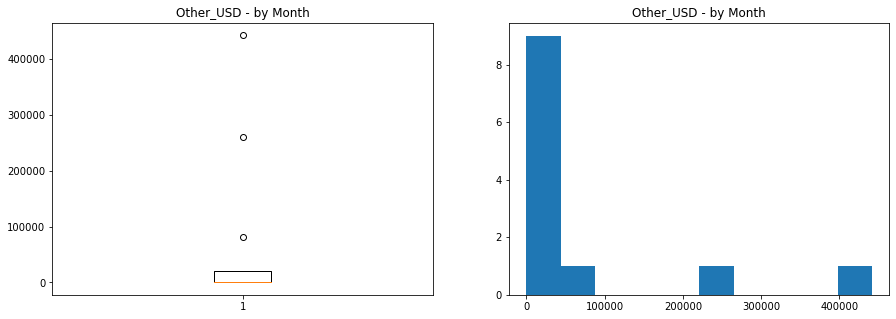

In [39]:
media_cols = ['Total_Investment_USD', 'TV_USD', 'Digital_USD','Sponsorship_USD', 'Content_Marketing_USD', 
              'Online_Marketing_USD','Affiliates_USD', 'SEM_USD', 'Radio_USD', 'Other_USD']

def distribution_plots(df, col):
    plt.figure(figsize=(15,5))
    plt.subplot(1,2,1)
    plt.boxplot(df[col])
    plt.title(col + ' - by Month')
    
    plt.subplot(1,2,2)
    plt.hist(df[col])
    plt.title(col + ' - by Month')
    plt.show()
    
for col in media_cols:
    distribution_plots(media_df, col)

In [40]:
#View monthly ad spend by channel crosstab

media_df_perc = media_df[['Month_Year','Total_Investment_USD']].copy()
col_list = ['TV_USD', 'Digital_USD','Sponsorship_USD','Content_Marketing_USD', 'Online_Marketing_USD','Affiliates_USD', 'SEM_USD', 'Radio_USD','Other_USD']

for i in col_list:
    media_df_perc[i + '_perc'] = round((media_df[i] / media_df['Total_Investment_USD'] * 100),2)
                         
media_df_perc.T      

,0,1,2,3,4,5,6,7,8,9,10,11
Month_Year,2015-07,2015-08,2015-09,2015-10,2015-11,2015-12,2016-01,2016-02,2016-03,2016-04,2016-05,2016-06
Total_Investment_USD,278730,83130,1.56969e+06,2.77426e+06,834560,1.73921e+06,1.20946e+06,784030,1.63e+06,925840,1.27303e+06,697640
TV_USD_perc,1.17,0,4.05,3.58,8.2,5.06,5.93,5.41,9.3,9.15,1.79,3.97
Digital_USD_perc,14.62,25.49,1.45,7.4,2.54,2.91,0.67,3.95,2.1,1.58,1.02,3.27
Sponsorship_USD_perc,43.27,21.57,65.21,49.76,27.73,53.14,5.66,24.32,41.6,42.78,40.59,58.41
Content_Marketing_USD_perc,0,0,0.62,2,0.39,1.03,1.21,1.25,0.4,0,1.02,0
Online_Marketing_USD_perc,7.6,1.96,17.03,14.34,38.28,21.09,30.86,41.37,18.4,29.05,30.35,18.69
Affiliates_USD_perc,2.92,1.96,5.19,4.11,12.89,6.37,9.97,13.51,6.2,10.04,8.71,6.54
SEM_USD_perc,29.24,49.02,6.44,18.74,10.16,10.5,5.66,10.19,5.2,7.39,8.83,8.64
Radio_USD_perc,0,0,0,0,0,0,3.64,0,0.9,0,1.41,0


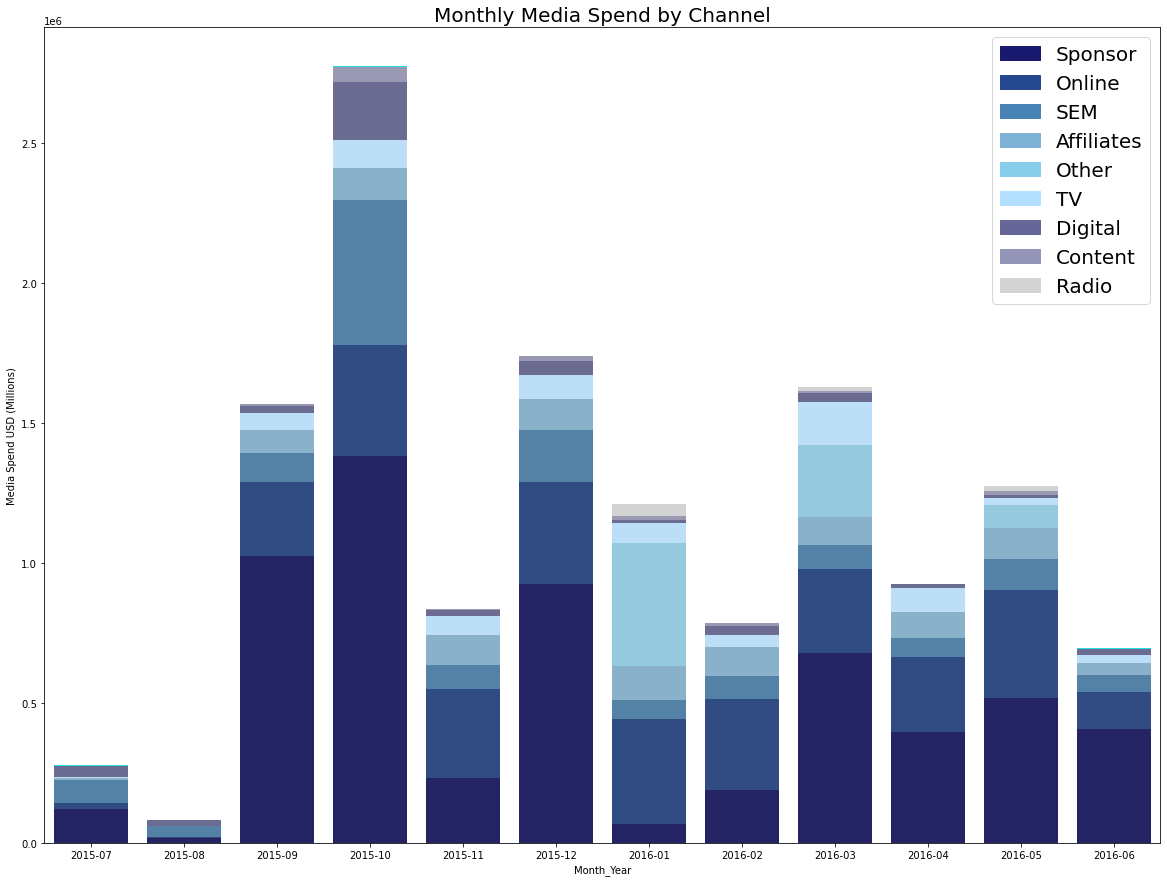

In [41]:
#View monthly ad spend by channel - visual

#Set figure size
plt.figure(figsize=(20,15))

#Create bottoms (this will be the bottom boundary for each stack)
bottom_2 = np.add(media_df['Sponsorship_USD'],media_df['Online_Marketing_USD'])
bottom_3 = media_df['Sponsorship_USD']+ media_df['Online_Marketing_USD'] + media_df['SEM_USD']
bottom_4 = media_df['Sponsorship_USD'] + media_df['Online_Marketing_USD'] + media_df['SEM_USD'] + media_df['Affiliates_USD']
bottom_5 = media_df['Sponsorship_USD'] + media_df['Online_Marketing_USD'] + media_df['SEM_USD'] + media_df['Affiliates_USD'] + media_df['Other_USD']
bottom_6 = media_df['Sponsorship_USD'] + media_df['Online_Marketing_USD'] + media_df['SEM_USD'] + media_df['Affiliates_USD'] + media_df['Other_USD'] + media_df['TV_USD']
bottom_7 = media_df['Sponsorship_USD'] + media_df['Online_Marketing_USD'] + media_df['SEM_USD'] + media_df['Affiliates_USD'] + media_df['Other_USD'] + media_df['TV_USD'] + media_df['Digital_USD']
bottom_8 = media_df['Sponsorship_USD'] + media_df['Online_Marketing_USD'] + media_df['SEM_USD'] + media_df['Affiliates_USD'] + media_df['Other_USD'] + media_df['TV_USD'] + media_df['Digital_USD'] + media_df['Content_Marketing_USD']

bar1 = sns.barplot(x='Month_Year',  y='Total_Investment_USD', data=media_df, color = '#00ffff')
bar2 = sns.barplot(x='Month_Year', y='Sponsorship_USD', data=media_df, color='midnightblue')
bar3 = sns.barplot(x='Month_Year', y='Online_Marketing_USD', bottom=media_df['Sponsorship_USD'], data=media_df, color='#24478f')
bar4 = sns.barplot(x='Month_Year', y='SEM_USD', data=media_df, bottom=bottom_2, color='steelblue')
bar5 = sns.barplot(x='Month_Year', y='Affiliates_USD', data=media_df, bottom=bottom_3, color='#7FB3D5')
bar6 = sns.barplot(x='Month_Year', y='Other_USD', data=media_df, bottom=bottom_4, color='skyblue')
bar7 = sns.barplot(x='Month_Year', y='TV_USD', data=media_df, bottom=bottom_5, color='#b3e0ff')
bar8 = sns.barplot(x='Month_Year', y='Digital_USD',bottom=bottom_6, data=media_df, color='#666699')
bar9 = sns.barplot(x='Month_Year', y='Content_Marketing_USD',bottom=bottom_7, data=media_df, color='#9494b8')
bar10 =sns.barplot(x='Month_Year', y='Radio_USD',bottom=bottom_8, data=media_df, color='lightgray')

# add legend
Sponsor_bar = mpatches.Patch(color='midnightblue', label='Sponsor')
Online_bar = mpatches.Patch(color='#24478f', label='Online')
SEM_bar = mpatches.Patch(color='steelblue', label='SEM')
Affiliates_bar = mpatches.Patch(color='#7FB3D5', label='Affiliates')
Other_bar = mpatches.Patch(color='skyblue', label='Other')
TV_bar = mpatches.Patch(color='#b3e0ff', label='TV')
Digital_bar = mpatches.Patch(color='#666699', label='Digital')
Content_bar = mpatches.Patch(color='#9494b8', label='Content')
Radio_bar = mpatches.Patch(color='lightgray', label='Radio')

#Digital_bar = mpatches.Patch(color='pink', label='Digital')
plt.legend(handles=[Sponsor_bar,Online_bar,SEM_bar,Affiliates_bar,Other_bar,TV_bar,Digital_bar,Content_bar,Radio_bar], fontsize=20)
plt.title('Monthly Media Spend by Channel',fontsize=20)
plt.ylabel('Media Spend USD (Millions)')

# show the graph
plt.show()



#### Notes: 
* Across the fiscal year, Sponsorships, Online Marketing, and SEM had the highest average monthly media spend.
* Sponsorships made up between 40% and 50% of the entire monthly media budget with the exception of that budget for Aug. 2015, Nov. 2015, Jan. 2016 and Feb. 2016 with Jan. 2016 being unusually low at 6%. 

### Time Series of Media Spend

In [42]:
#Create monthly aggregates of sales data to view against media investments
sales_df['Month_Year'] = sales_df['Date'].dt.strftime('%Y-%m')

#Calculate a monthly total for units and revenue
monthly_sales = sales_df[['units','revenue_USD','Month_Year']].groupby(['Month_Year']).sum().reset_index()

In [43]:
monthly_sales.head()

,Month_Year,units,revenue_USD
0,2015-07,85606,2.701174e+06
1,2015-08,258,6.548130e+03
2,2015-09,200239,6.465145e+06
3,2015-10,204001,7.965730e+06
4,2015-11,127035,5.171034e+06


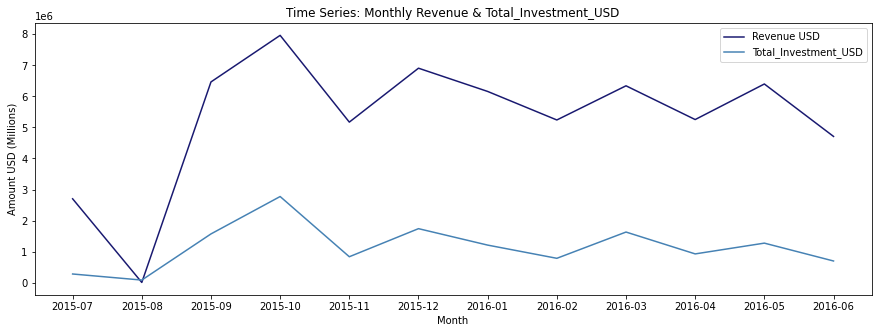

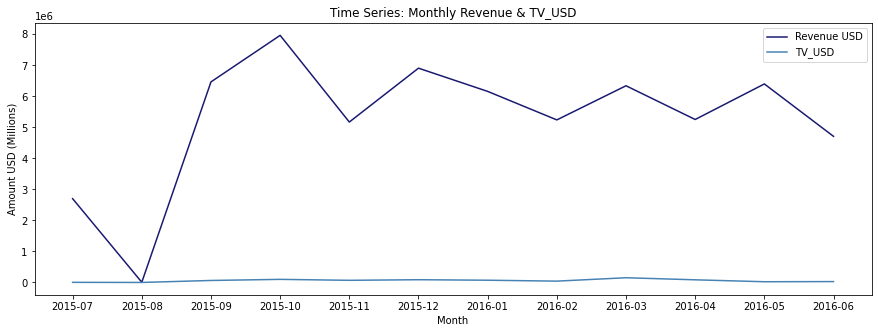

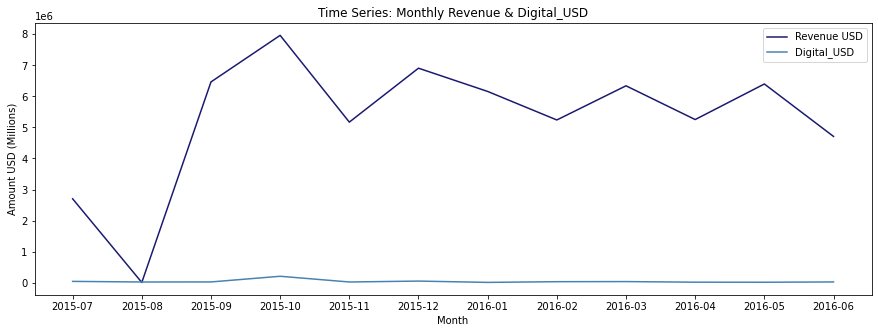

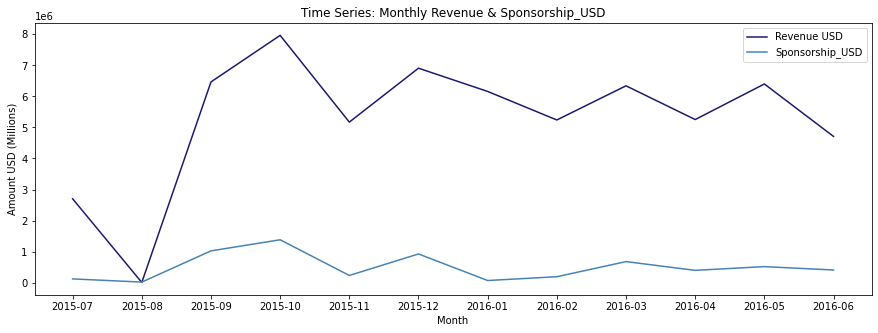

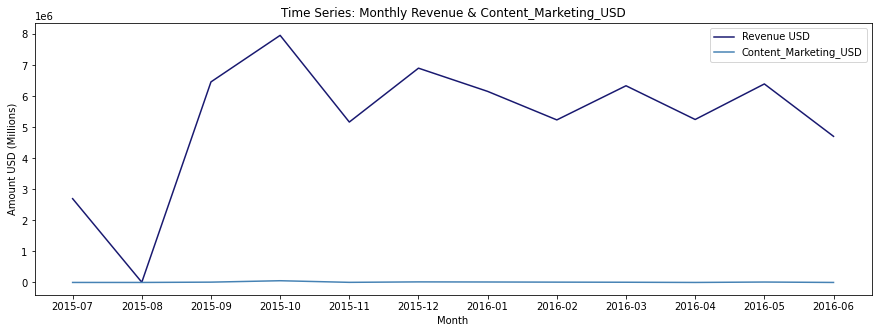

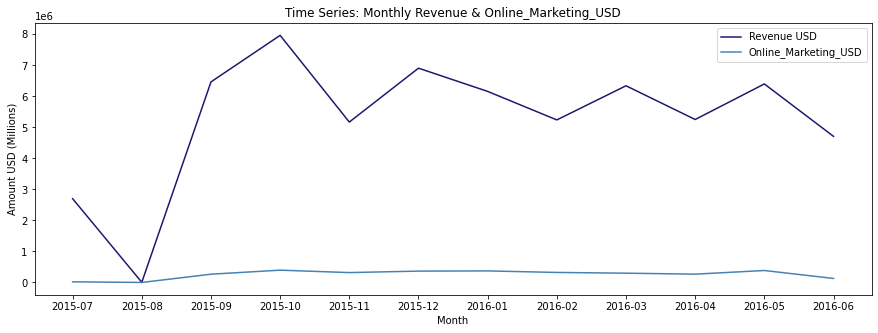

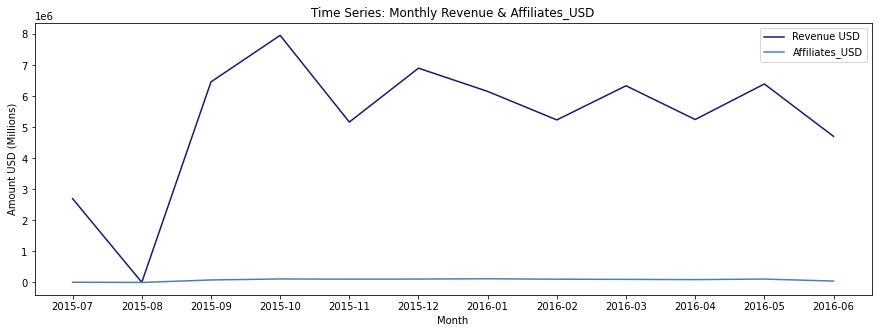

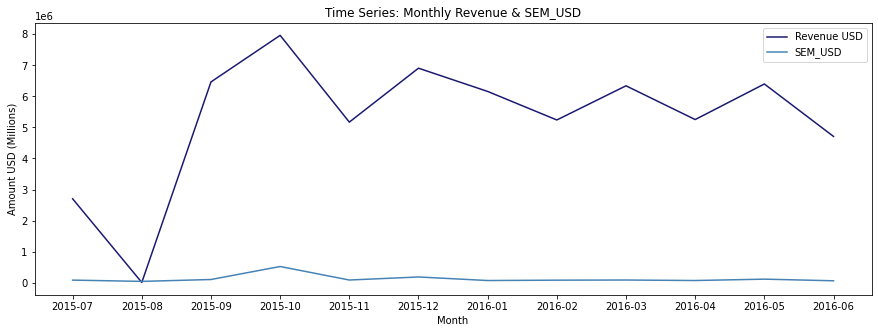

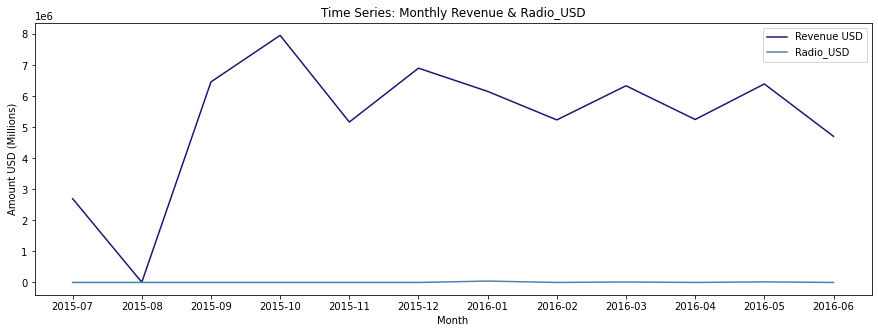

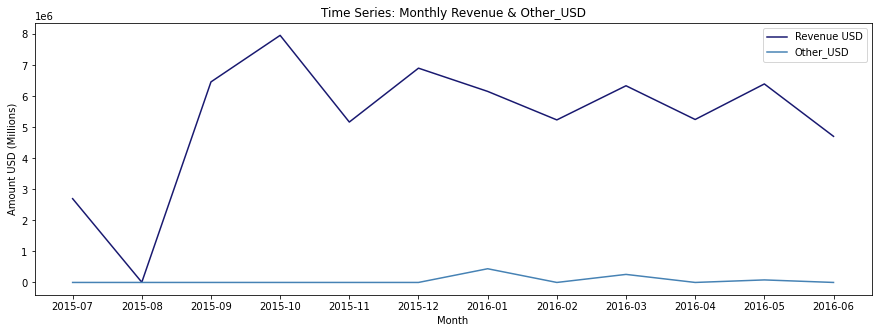

In [44]:
#Total Media Spend

def time_series_comp(col):
    plt.figure(figsize=(15,5))
    plt.plot(monthly_sales['Month_Year'], monthly_sales['revenue_USD'], color='midnightblue', label='Revenue USD')
    plt.plot(media_df['Month_Year'], media_df[col], color='steelblue', label=col)
    plt.xlabel('Month')
    plt.ylabel('Amount USD (Millions)')
    plt.title('Time Series: Monthly Revenue & '+ col)
    plt.legend()
    plt.show()

#Create plot
media_cols = ['Total_Investment_USD','TV_USD', 'Digital_USD','Sponsorship_USD','Content_Marketing_USD', 'Online_Marketing_USD','Affiliates_USD', 'SEM_USD', 'Radio_USD','Other_USD']

for i in media_cols:
    time_series_comp(i)

* Revenue was around 3M in July of 2015 and then dropped to under 1M in August. Revenue then peaked between September and October at nearly 8M and then dropped a bit but remain fairly consistent between 5M-7M for the remainder of the year.
* That trend was similar for the total media spend which appears to have been most impacted by the monthly sponsorship spend.

## D. Merge Sales & Media Data <a class="anchor" id="d"></a>

* Option 1: Split evenly by number of days
* Option 2: Generate random values that add up to monthly total for each media variable
* Option 3: Split proportionally by sales by day per month

#### Option 1: 
Split evenly by number of days (at day level)

In [45]:
#Reset index of daily sales to ensure consistency in merge
daily_sales_3day = daily_sales_3day.reset_index().drop(columns = 'index')

#Add month_year var to daily_sale for merge
daily_sales_3day['Month_Year'] = daily_sales_3day['Date'].dt.strftime('%Y-%m')

#Merge daily_sales and media_df
sales_media_1 = daily_sales_3day.merge(media_df.drop(columns = 'Date'), on='Month_Year', how='left')

print(sales_media_1.shape)
sales_media_1.head()

(358, 21)


,Date,units,revenue_USD,mrp_USD,discount_USD,promotion,prod_cam,prod_cam_assry,prod_small_ent,prod_gaming_hw,...,Total_Investment_USD,TV_USD,Digital_USD,Sponsorship_USD,Content_Marketing_USD,Online_Marketing_USD,Affiliates_USD,SEM_USD,Radio_USD,Other_USD
0,2015-07-04,96.000000,3378.216667,5701.436667,2323.233333,0.0,3.000000,10.333333,61.666667,10.666667,...,278730.0,3260.0,40750.0,120620.0,0.0,21190.0,8150.0,81500.0,0.0,0.0
1,2015-07-05,86.666667,3277.723333,5461.070000,2183.356667,0.0,3.000000,10.000000,55.333333,9.666667,...,278730.0,3260.0,40750.0,120620.0,0.0,21190.0,8150.0,81500.0,0.0,0.0
2,2015-07-06,16.000000,738.186667,1057.860000,319.670000,0.0,0.666667,0.333333,10.333333,3.333333,...,278730.0,3260.0,40750.0,120620.0,0.0,21190.0,8150.0,81500.0,0.0,0.0
3,2015-07-07,1541.333333,43652.226667,74333.196667,30680.616667,0.0,53.333333,173.666667,899.666667,325.333333,...,278730.0,3260.0,40750.0,120620.0,0.0,21190.0,8150.0,81500.0,0.0,0.0
4,2015-07-08,3238.666667,88125.926667,149918.863333,61793.006667,0.0,106.000000,387.333333,1999.666667,543.000000,...,278730.0,3260.0,40750.0,120620.0,0.0,21190.0,8150.0,81500.0,0.0,0.0


In [46]:
#Create a variable with a value of 1 for each row
sales_media_1['count'] = 1

#Create month_days df to get number of days in each month of data
month_days = sales_media_1.groupby(['Month_Year'])[['count']].sum().reset_index()

#Drop count from sales_media_1 so isn't duplicate in merge
sales_media_1 = sales_media_1.drop(columns='count')

#Merge month_days into sales_media_1
sales_media_1 = sales_media_1.merge(month_days, on='Month_Year', how='left')
sales_media_1.head()

,Date,units,revenue_USD,mrp_USD,discount_USD,promotion,prod_cam,prod_cam_assry,prod_small_ent,prod_gaming_hw,...,TV_USD,Digital_USD,Sponsorship_USD,Content_Marketing_USD,Online_Marketing_USD,Affiliates_USD,SEM_USD,Radio_USD,Other_USD,count
0,2015-07-04,96.000000,3378.216667,5701.436667,2323.233333,0.0,3.000000,10.333333,61.666667,10.666667,...,3260.0,40750.0,120620.0,0.0,21190.0,8150.0,81500.0,0.0,0.0,28
1,2015-07-05,86.666667,3277.723333,5461.070000,2183.356667,0.0,3.000000,10.000000,55.333333,9.666667,...,3260.0,40750.0,120620.0,0.0,21190.0,8150.0,81500.0,0.0,0.0,28
2,2015-07-06,16.000000,738.186667,1057.860000,319.670000,0.0,0.666667,0.333333,10.333333,3.333333,...,3260.0,40750.0,120620.0,0.0,21190.0,8150.0,81500.0,0.0,0.0,28
3,2015-07-07,1541.333333,43652.226667,74333.196667,30680.616667,0.0,53.333333,173.666667,899.666667,325.333333,...,3260.0,40750.0,120620.0,0.0,21190.0,8150.0,81500.0,0.0,0.0,28
4,2015-07-08,3238.666667,88125.926667,149918.863333,61793.006667,0.0,106.000000,387.333333,1999.666667,543.000000,...,3260.0,40750.0,120620.0,0.0,21190.0,8150.0,81500.0,0.0,0.0,28


In [47]:
#Create list of media data columns
col_list = ['Total_Investment_USD','TV_USD','Digital_USD','Sponsorship_USD','Content_Marketing_USD','Online_Marketing_USD','Affiliates_USD','SEM_USD','Radio_USD','Other_USD']


#Divide all media values by count
for i in col_list:
    sales_media_1[i] = sales_media_1[i] / sales_media_1['count']
    
#Check work
sales_media_1.head()

,Date,units,revenue_USD,mrp_USD,discount_USD,promotion,prod_cam,prod_cam_assry,prod_small_ent,prod_gaming_hw,...,TV_USD,Digital_USD,Sponsorship_USD,Content_Marketing_USD,Online_Marketing_USD,Affiliates_USD,SEM_USD,Radio_USD,Other_USD,count
0,2015-07-04,96.000000,3378.216667,5701.436667,2323.233333,0.0,3.000000,10.333333,61.666667,10.666667,...,116.428571,1455.357143,4307.857143,0.0,756.785714,291.071429,2910.714286,0.0,0.0,28
1,2015-07-05,86.666667,3277.723333,5461.070000,2183.356667,0.0,3.000000,10.000000,55.333333,9.666667,...,116.428571,1455.357143,4307.857143,0.0,756.785714,291.071429,2910.714286,0.0,0.0,28
2,2015-07-06,16.000000,738.186667,1057.860000,319.670000,0.0,0.666667,0.333333,10.333333,3.333333,...,116.428571,1455.357143,4307.857143,0.0,756.785714,291.071429,2910.714286,0.0,0.0,28
3,2015-07-07,1541.333333,43652.226667,74333.196667,30680.616667,0.0,53.333333,173.666667,899.666667,325.333333,...,116.428571,1455.357143,4307.857143,0.0,756.785714,291.071429,2910.714286,0.0,0.0,28
4,2015-07-08,3238.666667,88125.926667,149918.863333,61793.006667,0.0,106.000000,387.333333,1999.666667,543.000000,...,116.428571,1455.357143,4307.857143,0.0,756.785714,291.071429,2910.714286,0.0,0.0,28


In [48]:
#Drop count and month_year column
sales_media_1 = sales_media_1.drop(columns=['count','Month_Year'])

#Inspect for nulls
sales_media_1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 358 entries, 0 to 357
Data columns (total 20 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   Date                   358 non-null    datetime64[ns]
 1   units                  358 non-null    float64       
 2   revenue_USD            358 non-null    float64       
 3   mrp_USD                358 non-null    float64       
 4   discount_USD           358 non-null    float64       
 5   promotion              358 non-null    float64       
 6   prod_cam               358 non-null    float64       
 7   prod_cam_assry         358 non-null    float64       
 8   prod_small_ent         358 non-null    float64       
 9   prod_gaming_hw         358 non-null    float64       
 10  Total_Investment_USD   358 non-null    float64       
 11  TV_USD                 358 non-null    float64       
 12  Digital_USD            358 non-null    float64       
 13  Spons

In [193]:
#View descriptives for media spend variables

media_cols = ['Total_Investment_USD','TV_USD', 'Digital_USD','Sponsorship_USD','Content_Marketing_USD', 'Online_Marketing_USD','Affiliates_USD', 'SEM_USD', 'Radio_USD','Other_USD']
sales_media_1[media_cols].describe()

,Total_Investment_USD,TV_USD,Digital_USD,Sponsorship_USD,Content_Marketing_USD,Online_Marketing_USD,Affiliates_USD,SEM_USD,Radio_USD,Other_USD
count,358.000000,358.000000,358.000000,358.000000,358.000000,358.000000,358.000000,358.000000,358.000000,358.000000
mean,38546.312849,2021.564246,1356.815642,16636.927374,364.245810,8819.301676,2795.586592,4147.849162,213.994413,2185.474860
std,22043.948524,1347.372084,1670.229905,13264.261997,480.979911,4171.719426,1260.700347,4033.070841,421.410844,4417.137150
min,3197.307692,0.000000,262.903226,689.615385,0.000000,62.692308,62.692308,1567.307692,0.000000,0.000000
25%,27035.517241,923.666667,489.000000,6576.206897,0.000000,8910.666667,2716.666667,2282.000000,0.000000,0.000000
50%,39014.838710,2282.000000,760.666667,13583.333333,326.000000,10649.333333,3575.483871,2825.333333,0.000000,0.000000
75%,52580.645161,2839.354839,1367.566244,29813.225806,473.225806,12040.967742,3653.448276,3628.064516,473.225806,2629.032258
max,89492.258065,4890.000000,6625.161290,44535.806452,1787.741935,12829.677419,3890.967742,16773.225806,1419.677419,14249.354839


#### Option 2:
Generate random values that add up to monthly total for each media variable

In [123]:
#Merge daily_sales and media_df
sales_media_2 = daily_sales_3day.merge(media_df.drop(columns = 'Date'), on='Month_Year', how='left')

#Sort values by month_year
sales_media_2 = sales_media_2.sort_values(by='Month_Year')

#Sort media_df by month_year
media_df = media_df.sort_values(by='Month_Year')

#Check
print(sales_media_2.shape)
sales_media_2.head()

(358, 21)


,Date,units,revenue_USD,mrp_USD,discount_USD,promotion,prod_cam,prod_cam_assry,prod_small_ent,prod_gaming_hw,...,Total_Investment_USD,TV_USD,Digital_USD,Sponsorship_USD,Content_Marketing_USD,Online_Marketing_USD,Affiliates_USD,SEM_USD,Radio_USD,Other_USD
0,2015-07-04,96.000000,3378.216667,5701.436667,2323.233333,0.0,3.000000,10.333333,61.666667,10.666667,...,278730.0,3260.0,40750.0,120620.0,0.0,21190.0,8150.0,81500.0,0.0,0.0
27,2015-07-31,3100.333333,99822.130000,199201.566667,99381.633333,0.0,122.333333,426.000000,1947.333333,403.666667,...,278730.0,3260.0,40750.0,120620.0,0.0,21190.0,8150.0,81500.0,0.0,0.0
26,2015-07-30,3131.333333,103882.280000,204707.683333,100827.803333,0.0,125.000000,438.333333,1966.333333,405.000000,...,278730.0,3260.0,40750.0,120620.0,0.0,21190.0,8150.0,81500.0,0.0,0.0
25,2015-07-29,3047.666667,104355.433333,192926.280000,88573.290000,0.0,132.333333,432.000000,1910.333333,379.000000,...,278730.0,3260.0,40750.0,120620.0,0.0,21190.0,8150.0,81500.0,0.0,0.0
24,2015-07-28,3155.333333,105385.033333,179788.493333,74405.973333,0.0,125.333333,438.666667,1990.000000,391.666667,...,278730.0,3260.0,40750.0,120620.0,0.0,21190.0,8150.0,81500.0,0.0,0.0


In [124]:
#Create list of monthly media investment values for each media variable
total_1 = media_df['Total_Investment_USD'].to_list()
total_1 = [int(x) for x in total_1] #Converts to integer to enter in to function
total_1 = [999 if i==0 else i for i in total_1] #Convert 0 to 999 to be able to use in function, replace later

total_2 = media_df['TV_USD'].to_list()
total_2 = [int(x) for x in total_2]
total_2 = [999 if i==0 else i for i in total_2]

total_3 = media_df['Digital_USD'].to_list()
total_3 = [int(x) for x in total_3]
total_3 = [999 if i==0 else i for i in total_3]

total_4 = media_df['Sponsorship_USD'].to_list()
total_4 = [int(x) for x in total_4]
total_4 = [999 if i==0 else i for i in total_4]

total_5 = media_df['Content_Marketing_USD'].to_list()
total_5 = [int(x) for x in total_5]
total_5 = [999 if i==0 else i for i in total_5]

total_6 = media_df['Online_Marketing_USD'].to_list()
total_6 = [int(x) for x in total_6]
total_6 = [999 if i==0 else i for i in total_6]

total_7 = media_df['Affiliates_USD'].to_list()
total_7 = [int(x) for x in total_7]
total_7 = [999 if i==0 else i for i in total_7]

total_8 = media_df['SEM_USD'].to_list()
total_8 = [int(x) for x in total_8]
total_8 = [999 if i==0 else i for i in total_8]

total_9 = media_df['Radio_USD'].to_list()
total_9 = [int(x) for x in total_9]
total_9 = [999 if i==0 else i for i in total_9]

total_10 = media_df['Radio_USD'].to_list()
total_10 = [int(x) for x in total_10]
total_10 = [999 if i==0 else i for i in total_10]

#Get number of days per month, then multiply by number of media variables
days = sales_media_2.groupby('Month_Year')['Month_Year'].count().to_list()

#### Random values function [Source]('https://stackoverflow.com/questions/3589214/generate-random-numbers-summing-to-a-predefined-value')

In [125]:
#Define function to generate random values

def constrained_sum_sample_pos(n, total):
    """Return a randomly chosen list of n positive integers summing to total.
    Each such list is equally likely to occur."""

    dividers = sorted(random.sample(range(1, total), n - 1))
    return [a - b for a, b in zip(dividers + [total], [0] + dividers)]

In [126]:
#Apply function to totals variables 

#Create empty lists to fill with random values for each media variable
list_1 = []
list_2 = []
list_3 = []
list_4 = []
list_5 = []
list_6 = []
list_7 = []
list_8 = []
list_9 = []
list_10 = []

#Set random seed to replicate outcome
random.seed(2)

#Apply function to randomly fill lists 1-10 corresponding to the 10 media vars
for i in range(len(days)):
    list_1.append(constrained_sum_sample_pos(days[i], total_1[i]))
    
for i in range(len(days)):
    list_2.append(constrained_sum_sample_pos(days[i], total_2[i]))
    
for i in range(len(days)):
    list_3.append(constrained_sum_sample_pos(days[i], total_3[i]))

for i in range(len(days)):
    list_4.append(constrained_sum_sample_pos(days[i], total_4[i]))
    
for i in range(len(days)):
    list_5.append(constrained_sum_sample_pos(days[i], total_5[i]))

for i in range(len(days)):
    list_6.append(constrained_sum_sample_pos(days[i], total_6[i]))
    
for i in range(len(days)):
    list_7.append(constrained_sum_sample_pos(days[i], total_7[i]))

for i in range(len(days)):
    list_8.append(constrained_sum_sample_pos(days[i], total_8[i]))
    
for i in range(len(days)):
    list_9.append(constrained_sum_sample_pos(days[i], total_9[i]))

for i in range(len(days)):
    list_10.append(constrained_sum_sample_pos(days[i], total_10[i]))
    
#Flatted each list
flat_list_1 = [item for sublist in list_1 for item in sublist]
flat_list_2 = [item for sublist in list_2 for item in sublist]
flat_list_3 = [item for sublist in list_3 for item in sublist]
flat_list_4 = [item for sublist in list_4 for item in sublist]
flat_list_5 = [item for sublist in list_5 for item in sublist]
flat_list_6 = [item for sublist in list_6 for item in sublist]
flat_list_7 = [item for sublist in list_7 for item in sublist]
flat_list_8 = [item for sublist in list_8 for item in sublist]
flat_list_9 = [item for sublist in list_9 for item in sublist]
flat_list_10 = [item for sublist in list_10 for item in sublist]

#Check that len matches len of df (358)
print(len(flat_list_1)) 
print(len(flat_list_2)) 
print(len(flat_list_3)) 
print(len(flat_list_4)) 
print(len(flat_list_5)) 
print(len(flat_list_6)) 
print(len(flat_list_7)) 
print(len(flat_list_8)) 
print(len(flat_list_9)) 
print(len(flat_list_10))

358
358
358
358
358
358
358
358
358
358


In [127]:
#Merge each list with 
sales_media_2['Total_Investment_USD_rand'] = flat_list_1
sales_media_2['TV_USD_rand'] = flat_list_2
sales_media_2['Digital_USD_rand'] = flat_list_3
sales_media_2['Sponsorship_USD_rand'] = flat_list_4
sales_media_2['Content_Marketing_USD_rand'] = flat_list_5
sales_media_2['Online_Marketing_USD_rand'] = flat_list_6
sales_media_2['Affiliates_USD_rand'] = flat_list_7
sales_media_2['SEM_USD_rand'] = flat_list_8
sales_media_2['Radio_USD_rand'] = flat_list_9
sales_media_2['Other_USD_rand'] = flat_list_10
sales_media_2.head()

,Date,units,revenue_USD,mrp_USD,discount_USD,promotion,prod_cam,prod_cam_assry,prod_small_ent,prod_gaming_hw,...,Total_Investment_USD_rand,TV_USD_rand,Digital_USD_rand,Sponsorship_USD_rand,Content_Marketing_USD_rand,Online_Marketing_USD_rand,Affiliates_USD_rand,SEM_USD_rand,Radio_USD_rand,Other_USD_rand
0,2015-07-04,96.000000,3378.216667,5701.436667,2323.233333,0.0,3.000000,10.333333,61.666667,10.666667,...,14390,154,580,6166,41,240,394,6733,65,1
27,2015-07-31,3100.333333,99822.130000,199201.566667,99381.633333,0.0,122.333333,426.000000,1947.333333,403.666667,...,4346,120,1055,6591,23,457,166,2765,88,97
26,2015-07-30,3131.333333,103882.280000,204707.683333,100827.803333,0.0,125.000000,438.333333,1966.333333,405.000000,...,99,18,1390,1274,16,63,299,757,59,19
25,2015-07-29,3047.666667,104355.433333,192926.280000,88573.290000,0.0,132.333333,432.000000,1910.333333,379.000000,...,10815,54,237,21137,49,236,484,384,12,1
24,2015-07-28,3155.333333,105385.033333,179788.493333,74405.973333,0.0,125.333333,438.666667,1990.000000,391.666667,...,14848,7,1807,948,29,3,393,1655,26,14


In [130]:
#Replace months with 0
sales_media_2['Total_Investment_USD_rand'] = np.where((sales_media_2['Total_Investment_USD']==0),0,sales_media_2['Total_Investment_USD_rand'])
sales_media_2['TV_USD_rand'] = np.where((sales_media_2['TV_USD']==0),0,sales_media_2['TV_USD_rand'])
sales_media_2['Digital_USD_rand'] = np.where((sales_media_2['Digital_USD']==0),0,sales_media_2['Digital_USD_rand'])
sales_media_2['Sponsorship_USD_rand'] = np.where((sales_media_2['Sponsorship_USD']==0),0,sales_media_2['Sponsorship_USD_rand'])
sales_media_2['Content_Marketing_USD_rand'] = np.where((sales_media_2['Content_Marketing_USD']==0),0,sales_media_2['Content_Marketing_USD_rand'])
sales_media_2['Online_Marketing_USD_rand'] = np.where((sales_media_2['Online_Marketing_USD']==0),0,sales_media_2['Online_Marketing_USD_rand'])
sales_media_2['Affiliates_USD_rand'] = np.where((sales_media_2['Affiliates_USD']==0),0,sales_media_2['Affiliates_USD_rand'])
sales_media_2['SEM_USD_rand'] = np.where((sales_media_2['SEM_USD']==0),0,sales_media_2['SEM_USD_rand'])
sales_media_2['Radio_USD_rand'] = np.where((sales_media_2['Radio_USD']==0),0,sales_media_2['Radio_USD_rand'])
sales_media_2['Other_USD_rand'] = np.where((sales_media_2['Other_USD']==0),0,sales_media_2['Other_USD_rand'])

In [133]:
#Check sums against original for one var
#print(sales_media_2.groupby('Month_Year')['Total_Investment_USD_rand'].sum())
#print(sales_media_2.groupby('Month_Year')['Total_Investment_USD'].value_counts())
#print(sales_media_2.groupby('Month_Year')['Radio_USD_rand'].sum())
#print(sales_media_2.groupby('Month_Year')['Radio_USD'].value_counts())

In [134]:
sales_media_2.columns

Index(['Date', 'units', 'revenue_USD', 'mrp_USD', 'discount_USD', 'promotion',
       'prod_cam', 'prod_cam_assry', 'prod_small_ent', 'prod_gaming_hw',
       'Month_Year', 'Total_Investment_USD', 'TV_USD', 'Digital_USD',
       'Sponsorship_USD', 'Content_Marketing_USD', 'Online_Marketing_USD',
       'Affiliates_USD', 'SEM_USD', 'Radio_USD', 'Other_USD',
       'Total_Investment_USD_rand', 'TV_USD_rand', 'Digital_USD_rand',
       'Sponsorship_USD_rand', 'Content_Marketing_USD_rand',
       'Online_Marketing_USD_rand', 'Affiliates_USD_rand', 'SEM_USD_rand',
       'Radio_USD_rand', 'Other_USD_rand'],
      dtype='object')

In [135]:
#Drop month level media spend vars and month_year column
sales_media_2 = sales_media_2.drop(columns=['Month_Year', 'Total_Investment_USD', 'TV_USD', 'Digital_USD',
       'Sponsorship_USD', 'Content_Marketing_USD', 'Online_Marketing_USD',
       'Affiliates_USD', 'SEM_USD', 'Radio_USD', 'Other_USD'])

#Inspect for nulls
sales_media_2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 358 entries, 0 to 357
Data columns (total 20 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   Date                        358 non-null    datetime64[ns]
 1   units                       358 non-null    float64       
 2   revenue_USD                 358 non-null    float64       
 3   mrp_USD                     358 non-null    float64       
 4   discount_USD                358 non-null    float64       
 5   promotion                   358 non-null    float64       
 6   prod_cam                    358 non-null    float64       
 7   prod_cam_assry              358 non-null    float64       
 8   prod_small_ent              358 non-null    float64       
 9   prod_gaming_hw              358 non-null    float64       
 10  Total_Investment_USD_rand   358 non-null    int64         
 11  TV_USD_rand                 358 non-null    int64         

In [148]:
# rename vars to match other dfs
sales_media_2 = sales_media_2.rename(columns={'Total_Investment_USD_rand':'Total_Investment_USD', 'TV_USD_rand':'TV_USD', 'Digital_USD_rand':'Digital_USD',
 'Sponsorship_USD_rand':'Sponsorship_USD','Content_Marketing_USD_rand':'Content_Marketing_USD', 'Online_Marketing_USD_rand':'Online_Marketing_USD',
  'Affiliates_USD_rand':'Affiliates_USD', 'SEM_USD_rand':'SEM_USD', 'Radio_USD_rand':'Radio_USD', 'Other_USD_rand':'Other_USD'})
sales_media_2.columns


Index(['Date', 'units', 'revenue_USD', 'mrp_USD', 'discount_USD', 'promotion',
       'prod_cam', 'prod_cam_assry', 'prod_small_ent', 'prod_gaming_hw',
       'Total_Investment_USD', 'TV_USD', 'Digital_USD', 'Sponsorship_USD',
       'Content_Marketing_USD', 'Online_Marketing_USD', 'Affiliates_USD',
       'SEM_USD', 'Radio_USD', 'Other_USD'],
      dtype='object')

In [194]:
#View descriptives
media_cols = ['Total_Investment_USD','TV_USD', 'Digital_USD','Sponsorship_USD','Content_Marketing_USD', 'Online_Marketing_USD','Affiliates_USD', 'SEM_USD', 'Radio_USD','Other_USD']
sales_media_2[media_cols].describe()

,Total_Investment_USD,TV_USD,Digital_USD,Sponsorship_USD,Content_Marketing_USD,Online_Marketing_USD,Affiliates_USD,SEM_USD,Radio_USD,Other_USD
count,358.000000,358.000000,358.000000,358.000000,358.000000,358.000000,358.000000,358.000000,358.000000,358.000000
mean,38546.312849,2021.564246,1356.815642,16636.927374,364.245810,8819.301676,2795.586592,4147.849162,213.994413,213.994413
std,48229.439763,2570.145068,2469.582352,26177.142136,745.027667,10328.714170,3171.316361,7326.443956,663.768825,545.079836
min,8.000000,0.000000,1.000000,15.000000,0.000000,3.000000,3.000000,4.000000,0.000000,0.000000
25%,6995.500000,253.750000,232.500000,2331.750000,0.000000,1518.250000,526.000000,818.250000,0.000000,0.000000
50%,20654.000000,1110.500000,611.500000,6568.500000,100.000000,5106.000000,1800.000000,2189.000000,0.000000,0.000000
75%,51736.000000,2741.500000,1390.750000,19411.250000,386.000000,12679.000000,3990.250000,4217.750000,26.500000,41.750000
max,348274.000000,19050.000000,22143.000000,272009.000000,6840.000000,67369.000000,20748.000000,72331.000000,6662.000000,3213.000000


#### Option 3: 
Split proportionately by sales per day per month

In [136]:
#Merge daily_sales and media_df
sales_media_3 = daily_sales_3day.merge(media_df.drop(columns = 'Date'), on='Month_Year', how='left')

print(sales_media_1.shape)
sales_media_3.head()

(358, 20)


,Date,units,revenue_USD,mrp_USD,discount_USD,promotion,prod_cam,prod_cam_assry,prod_small_ent,prod_gaming_hw,...,Total_Investment_USD,TV_USD,Digital_USD,Sponsorship_USD,Content_Marketing_USD,Online_Marketing_USD,Affiliates_USD,SEM_USD,Radio_USD,Other_USD
0,2015-07-04,96.000000,3378.216667,5701.436667,2323.233333,0.0,3.000000,10.333333,61.666667,10.666667,...,278730.0,3260.0,40750.0,120620.0,0.0,21190.0,8150.0,81500.0,0.0,0.0
1,2015-07-05,86.666667,3277.723333,5461.070000,2183.356667,0.0,3.000000,10.000000,55.333333,9.666667,...,278730.0,3260.0,40750.0,120620.0,0.0,21190.0,8150.0,81500.0,0.0,0.0
2,2015-07-06,16.000000,738.186667,1057.860000,319.670000,0.0,0.666667,0.333333,10.333333,3.333333,...,278730.0,3260.0,40750.0,120620.0,0.0,21190.0,8150.0,81500.0,0.0,0.0
3,2015-07-07,1541.333333,43652.226667,74333.196667,30680.616667,0.0,53.333333,173.666667,899.666667,325.333333,...,278730.0,3260.0,40750.0,120620.0,0.0,21190.0,8150.0,81500.0,0.0,0.0
4,2015-07-08,3238.666667,88125.926667,149918.863333,61793.006667,0.0,106.000000,387.333333,1999.666667,543.000000,...,278730.0,3260.0,40750.0,120620.0,0.0,21190.0,8150.0,81500.0,0.0,0.0


In [137]:
#Create month_sales df to get number of sales in each month of data
month_sales_count = sales_media_3.groupby(['Month_Year'])[['units']].sum().reset_index()

#Rename 'units' variable to 'monthly_sales'
month_sales_count = month_sales_count.rename(columns = {'units':'monthly_sales'})

#Merge month_sales_count into sales_media_3
sales_media_3 = sales_media_3.merge(month_sales_count, on='Month_Year', how='left')
sales_media_3.head()

,Date,units,revenue_USD,mrp_USD,discount_USD,promotion,prod_cam,prod_cam_assry,prod_small_ent,prod_gaming_hw,...,TV_USD,Digital_USD,Sponsorship_USD,Content_Marketing_USD,Online_Marketing_USD,Affiliates_USD,SEM_USD,Radio_USD,Other_USD,monthly_sales
0,2015-07-04,96.000000,3378.216667,5701.436667,2323.233333,0.0,3.000000,10.333333,61.666667,10.666667,...,3260.0,40750.0,120620.0,0.0,21190.0,8150.0,81500.0,0.0,0.0,82453.0
1,2015-07-05,86.666667,3277.723333,5461.070000,2183.356667,0.0,3.000000,10.000000,55.333333,9.666667,...,3260.0,40750.0,120620.0,0.0,21190.0,8150.0,81500.0,0.0,0.0,82453.0
2,2015-07-06,16.000000,738.186667,1057.860000,319.670000,0.0,0.666667,0.333333,10.333333,3.333333,...,3260.0,40750.0,120620.0,0.0,21190.0,8150.0,81500.0,0.0,0.0,82453.0
3,2015-07-07,1541.333333,43652.226667,74333.196667,30680.616667,0.0,53.333333,173.666667,899.666667,325.333333,...,3260.0,40750.0,120620.0,0.0,21190.0,8150.0,81500.0,0.0,0.0,82453.0
4,2015-07-08,3238.666667,88125.926667,149918.863333,61793.006667,0.0,106.000000,387.333333,1999.666667,543.000000,...,3260.0,40750.0,120620.0,0.0,21190.0,8150.0,81500.0,0.0,0.0,82453.0


In [138]:
#Create a variable to get portion of monthly sales for that day
sales_media_3['daily_sales_pct'] = sales_media_3['units'] / sales_media_3['monthly_sales']

#Create list of media data columns
col_list = ['Total_Investment_USD','TV_USD','Digital_USD','Sponsorship_USD','Content_Marketing_USD','Online_Marketing_USD','Affiliates_USD','SEM_USD','Radio_USD','Other_USD']

#Multiply all media values by daily_sales_pct
for i in col_list:
    sales_media_3[i] = sales_media_3[i] * sales_media_3['daily_sales_pct']
    
#Check work
sales_media_3.head()

,Date,units,revenue_USD,mrp_USD,discount_USD,promotion,prod_cam,prod_cam_assry,prod_small_ent,prod_gaming_hw,...,Digital_USD,Sponsorship_USD,Content_Marketing_USD,Online_Marketing_USD,Affiliates_USD,SEM_USD,Radio_USD,Other_USD,monthly_sales,daily_sales_pct
0,2015-07-04,96.000000,3378.216667,5701.436667,2323.233333,0.0,3.000000,10.333333,61.666667,10.666667,...,47.445211,140.437825,0.0,24.671510,9.489042,94.890422,0.0,0.0,82453.0,0.001164
1,2015-07-05,86.666667,3277.723333,5461.070000,2183.356667,0.0,3.000000,10.000000,55.333333,9.666667,...,42.832482,126.784148,0.0,22.272891,8.566496,85.664965,0.0,0.0,82453.0,0.001051
2,2015-07-06,16.000000,738.186667,1057.860000,319.670000,0.0,0.666667,0.333333,10.333333,3.333333,...,7.907535,23.406304,0.0,4.111918,1.581507,15.815070,0.0,0.0,82453.0,0.000194
3,2015-07-07,1541.333333,43652.226667,74333.196667,30680.616667,0.0,53.333333,173.666667,899.666667,325.333333,...,761.759224,2254.807304,0.0,396.114797,152.351845,1523.518449,0.0,0.0,82453.0,0.018693
4,2015-07-08,3238.666667,88125.926667,149918.863333,61793.006667,0.0,106.000000,387.333333,1999.666667,543.000000,...,1600.616917,4737.826075,0.0,832.320797,320.123383,3201.233834,0.0,0.0,82453.0,0.039279


In [139]:
#Drop monthly_sales, daily_sales_pct, and month_year column
sales_media_3 = sales_media_3.drop(columns=['monthly_sales','daily_sales_pct','Month_Year'])

#Inspect for nulls
sales_media_3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 358 entries, 0 to 357
Data columns (total 20 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   Date                   358 non-null    datetime64[ns]
 1   units                  358 non-null    float64       
 2   revenue_USD            358 non-null    float64       
 3   mrp_USD                358 non-null    float64       
 4   discount_USD           358 non-null    float64       
 5   promotion              358 non-null    float64       
 6   prod_cam               358 non-null    float64       
 7   prod_cam_assry         358 non-null    float64       
 8   prod_small_ent         358 non-null    float64       
 9   prod_gaming_hw         358 non-null    float64       
 10  Total_Investment_USD   358 non-null    float64       
 11  TV_USD                 358 non-null    float64       
 12  Digital_USD            358 non-null    float64       
 13  Spons

In [196]:
#View descriptives
media_cols = ['Total_Investment_USD','TV_USD', 'Digital_USD','Sponsorship_USD','Content_Marketing_USD', 'Online_Marketing_USD','Affiliates_USD', 'SEM_USD', 'Radio_USD','Other_USD']
sales_media_3[media_cols].describe()

,Total_Investment_USD,TV_USD,Digital_USD,Sponsorship_USD,Content_Marketing_USD,Online_Marketing_USD,Affiliates_USD,SEM_USD,Radio_USD,Other_USD
count,358.000000,358.000000,358.000000,358.000000,358.000000,358.000000,358.000000,358.000000,358.000000,358.000000
mean,38546.312849,2021.564246,1356.815642,16636.927374,364.245810,8819.301676,2795.586592,4147.849162,213.994413,2185.474860
std,38963.854871,1892.913219,2914.799746,20613.596296,776.637987,6599.981016,1985.297318,7181.302658,432.761876,4537.822032
min,43.346543,0.000000,7.907535,9.349254,0.000000,0.849932,0.849932,15.815070,0.000000,0.000000
25%,22891.565333,797.608677,402.057556,5564.448161,0.000000,5309.618896,1668.891654,2167.201135,0.000000,0.000000
50%,35267.234687,1864.905938,816.566092,13136.773914,285.694188,9024.413236,2926.964038,2856.375386,0.000000,0.000000
75%,48243.148263,2482.897609,1333.652237,22082.893948,417.224494,11264.441827,3436.663910,3653.913782,394.568692,2302.367679
max,424939.377263,15229.907176,31458.496789,211471.006194,8488.800721,60919.628703,17476.942661,79644.924411,2433.407281,24424.199003


#### Notes:
Option 1 had the least amount of variability according to the standard deviation while option 2 had the most, which makes sense because values were selected randomly.

## E. Explore Relationships <a class="anchor" id="e"></a>

### Correlations

In [149]:
#Correlations: Option 1
sales_media_1.corr().sort_values(by='units', ascending=False)

,units,revenue_USD,mrp_USD,discount_USD,promotion,prod_cam,prod_cam_assry,prod_small_ent,prod_gaming_hw,Total_Investment_USD,TV_USD,Digital_USD,Sponsorship_USD,Content_Marketing_USD,Online_Marketing_USD,Affiliates_USD,SEM_USD,Radio_USD,Other_USD
units,1.000000,0.932127,0.937816,0.934806,0.756907,0.899845,0.881801,0.987920,0.947272,0.429251,0.299434,0.210448,0.384499,0.313261,0.403243,0.387327,0.273419,0.040075,0.038637
prod_small_ent,0.987920,0.894945,0.910299,0.918018,0.770279,0.873316,0.822990,1.000000,0.899010,0.420220,0.271511,0.252122,0.389471,0.332095,0.354119,0.334041,0.304131,0.001998,0.006099
prod_gaming_hw,0.947272,0.894950,0.884937,0.865452,0.647695,0.832612,0.904907,0.899010,1.000000,0.390467,0.306772,0.072219,0.317848,0.228218,0.472932,0.467728,0.155065,0.132621,0.116035
mrp_USD,0.937816,0.995662,1.000000,0.994918,0.836482,0.986820,0.765834,0.910299,0.884937,0.374504,0.282480,0.195829,0.300348,0.293287,0.369196,0.356328,0.251464,0.087817,0.087933
discount_USD,0.934806,0.981233,0.994918,1.000000,0.861238,0.981665,0.739287,0.918018,0.865452,0.365094,0.266678,0.222159,0.288625,0.308200,0.341104,0.326128,0.269190,0.085115,0.088398
revenue_USD,0.932127,1.000000,0.995662,0.981233,0.806048,0.982667,0.783450,0.894945,0.894950,0.379818,0.294531,0.169729,0.308468,0.276857,0.391820,0.381016,0.232812,0.089523,0.086712
prod_cam,0.899845,0.982667,0.986820,0.981665,0.852780,1.000000,0.709598,0.873316,0.832612,0.366655,0.275163,0.228541,0.286754,0.313333,0.358781,0.346086,0.278132,0.066046,0.067819
prod_cam_assry,0.881801,0.783450,0.765834,0.739287,0.497920,0.709598,1.000000,0.822990,0.904907,0.411486,0.305665,0.091672,0.373532,0.229340,0.456000,0.449569,0.171327,0.076426,0.057361
promotion,0.756907,0.806048,0.836482,0.861238,1.000000,0.852780,0.497920,0.770279,0.647695,0.206764,0.120401,0.227021,0.128876,0.255505,0.183267,0.169160,0.239598,0.052125,0.049972
Total_Investment_USD,0.429251,0.379818,0.374504,0.365094,0.206764,0.366655,0.411486,0.420220,0.390467,1.000000,0.689847,0.701621,0.895521,0.860370,0.726648,0.661163,0.804850,0.081918,0.116495


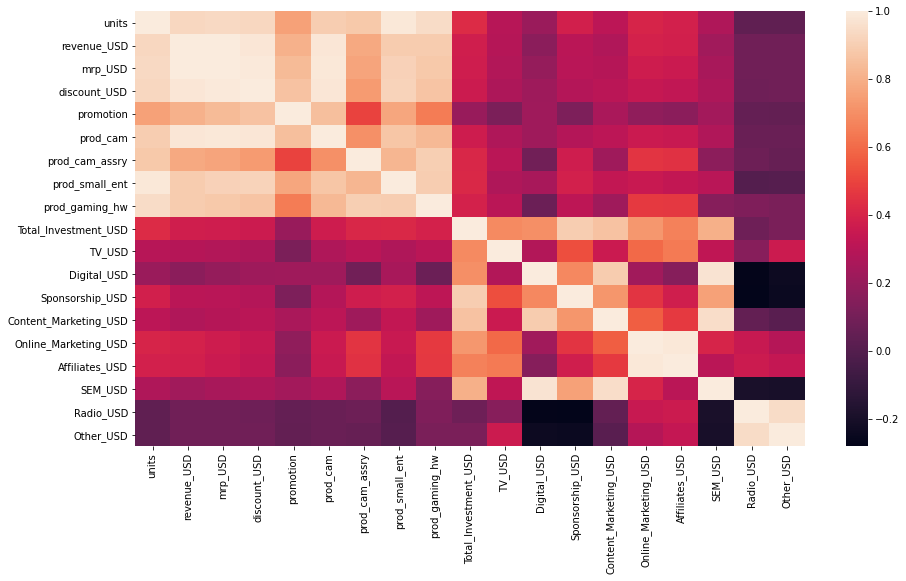

In [150]:
plt.subplots(figsize=(15,8))
sns.heatmap(sales_media_1.corr());

#### Option 1 Correlation Notes:
Of the control / baseline variables, units was most highly correlated with the small entertainment and gaming hardware product categories. Of the incremental variables, units sold was most highly correlated with the overall investment at .43 and online marketing spend at .4. There is also substantial multi-collinearity between the control/baseline variables as well as between the independent/incremental variables. This will need to be adjusted in preprocessing.

In [151]:
#Correlations: Option 2
sales_media_2.corr().sort_values(by='units', ascending=False)

,units,revenue_USD,mrp_USD,discount_USD,promotion,prod_cam,prod_cam_assry,prod_small_ent,prod_gaming_hw,Total_Investment_USD,TV_USD,Digital_USD,Sponsorship_USD,Content_Marketing_USD,Online_Marketing_USD,Affiliates_USD,SEM_USD,Radio_USD,Other_USD
units,1.000000,0.932127,0.937816,0.934806,0.756907,0.899845,0.881801,0.987920,0.947272,0.207767,0.186722,0.043073,0.167737,0.188305,0.207917,0.221040,0.201576,0.018717,0.015009
prod_small_ent,0.987920,0.894945,0.910299,0.918018,0.770279,0.873316,0.822990,1.000000,0.899010,0.203524,0.170636,0.062647,0.162101,0.198862,0.195451,0.205309,0.217298,-0.008027,-0.003023
prod_gaming_hw,0.947272,0.894950,0.884937,0.865452,0.647695,0.832612,0.904907,0.899010,1.000000,0.197498,0.192342,-0.025840,0.155456,0.136973,0.213803,0.223275,0.137913,0.070681,0.077433
mrp_USD,0.937816,0.995662,1.000000,0.994918,0.836482,0.986820,0.765834,0.910299,0.884937,0.179312,0.176131,0.038998,0.118396,0.175468,0.199343,0.192309,0.192997,0.061842,0.016019
discount_USD,0.934806,0.981233,0.994918,1.000000,0.861238,0.981665,0.739287,0.918018,0.865452,0.176454,0.169344,0.047197,0.107564,0.182144,0.188769,0.181848,0.200159,0.056564,0.017898
revenue_USD,0.932127,1.000000,0.995662,0.981233,0.806048,0.982667,0.783450,0.894945,0.894950,0.180335,0.180813,0.031068,0.127335,0.167713,0.207313,0.200239,0.184635,0.066162,0.014141
prod_cam,0.899845,0.982667,0.986820,0.981665,0.852780,1.000000,0.709598,0.873316,0.832612,0.179983,0.172264,0.067441,0.117797,0.186434,0.196713,0.205276,0.209744,0.053715,-0.006430
prod_cam_assry,0.881801,0.783450,0.765834,0.739287,0.497920,0.709598,1.000000,0.822990,0.904907,0.187907,0.175940,-0.018550,0.181203,0.146817,0.196023,0.215266,0.122327,0.044957,0.056624
promotion,0.756907,0.806048,0.836482,0.861238,1.000000,0.852780,0.497920,0.770279,0.647695,0.137871,0.115905,0.047775,0.015246,0.135920,0.171103,0.138852,0.168866,0.041250,0.008723
Affiliates_USD,0.221040,0.200239,0.192309,0.181848,0.138852,0.205276,0.215266,0.205309,0.223275,0.203830,0.227650,0.058843,0.021820,0.092757,0.183234,1.000000,0.113628,0.132302,0.077416


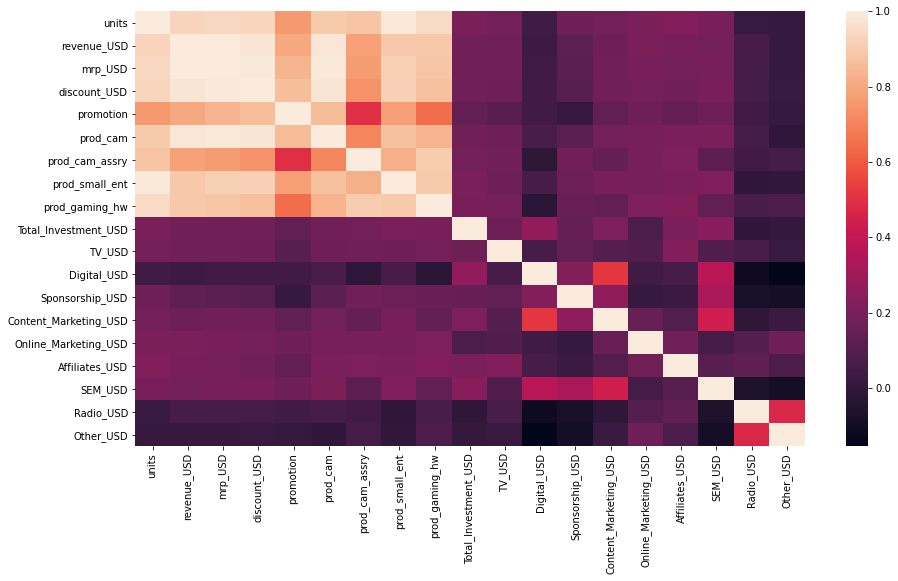

In [152]:
plt.subplots(figsize=(15,8))
sns.heatmap(sales_media_2.corr());

#### Option 2 Correlation Notes:
Randomly splitting the monthly media spends throughout the days resulted in very low correlations with units sold with the highest correlations being .22 for affiliates and .21 for online marketing. However, in this scenario, multi-collinearity was minimized quite a bit.

In [153]:
#Correlations: Option 3
sales_media_3.corr().sort_values(by='units', ascending=False)

,units,revenue_USD,mrp_USD,discount_USD,promotion,prod_cam,prod_cam_assry,prod_small_ent,prod_gaming_hw,Total_Investment_USD,TV_USD,Digital_USD,Sponsorship_USD,Content_Marketing_USD,Online_Marketing_USD,Affiliates_USD,SEM_USD,Radio_USD,Other_USD
units,1.000000,0.932127,0.937816,0.934806,0.756907,0.899845,0.881801,0.987920,0.947272,0.934433,0.801986,0.737700,0.881550,0.798866,0.914660,0.900813,0.801914,0.073001,0.071443
prod_small_ent,0.987920,0.894945,0.910299,0.918018,0.770279,0.873316,0.822990,1.000000,0.899010,0.945387,0.780832,0.790280,0.903988,0.839446,0.883851,0.863296,0.845776,0.023494,0.027532
prod_gaming_hw,0.947272,0.894950,0.884937,0.865452,0.647695,0.832612,0.904907,0.899010,1.000000,0.829239,0.765766,0.561744,0.756549,0.644672,0.901415,0.902679,0.638549,0.174527,0.159337
mrp_USD,0.937816,0.995662,1.000000,0.994918,0.836482,0.986820,0.765834,0.910299,0.884937,0.905736,0.789073,0.720118,0.823194,0.791570,0.904141,0.889960,0.783638,0.151503,0.150453
discount_USD,0.934806,0.981233,0.994918,1.000000,0.861238,0.981665,0.739287,0.918018,0.865452,0.922350,0.785787,0.764252,0.838152,0.831537,0.896229,0.877526,0.821618,0.145776,0.148296
Total_Investment_USD,0.934433,0.882201,0.905736,0.922350,0.799364,0.888569,0.738479,0.945387,0.829239,1.000000,0.824517,0.866659,0.953945,0.925164,0.876918,0.842082,0.918340,0.068824,0.088718
revenue_USD,0.932127,1.000000,0.995662,0.981233,0.806048,0.982667,0.783450,0.894945,0.894950,0.882201,0.784982,0.672829,0.801935,0.747487,0.903285,0.893412,0.741463,0.155428,0.151089
Online_Marketing_USD,0.914660,0.903285,0.904141,0.896229,0.731704,0.881567,0.805947,0.883851,0.901415,0.876918,0.803189,0.620964,0.750785,0.759752,1.000000,0.993228,0.711702,0.253789,0.218487
Affiliates_USD,0.900813,0.893412,0.889960,0.877526,0.703562,0.866046,0.811263,0.863296,0.902679,0.842082,0.825383,0.575878,0.703421,0.700659,0.993228,1.000000,0.663093,0.265411,0.247305
prod_cam,0.899845,0.982667,0.986820,0.981665,0.852780,1.000000,0.709598,0.873316,0.832612,0.888569,0.769651,0.730416,0.803513,0.799478,0.881567,0.866046,0.789141,0.127783,0.129582


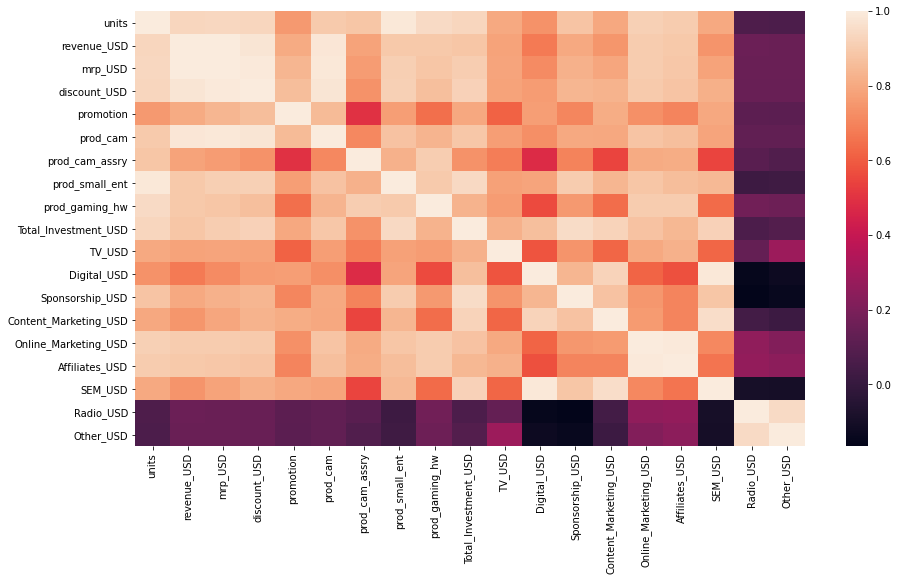

In [154]:
plt.subplots(figsize=(15,8))
sns.heatmap(sales_media_3.corr());

#### Notes on Option 3 Correlations:
Splitting the monthly media spend proportionately to the sales per day clearly created strong relationships that likely do not actually exist. This also resulted in high correlations between all variables with the exception of the radio and other media spend variables.


### Scatterplots

In [189]:
# scatterplots fuction adapted from Springboard Data Science Guided Capstone

def scatterplots(columns, y_col, df, ncol=None,figsize=(15,30)):
    if ncol is None: #Sets number of columns in subplot grid
        ncol = len(columns)
    nrow = int(np.ceil(len(columns) / ncol)) #calculates number of rows in subplot grid
    fig, axes = plt.subplots(nrow, ncol, figsize=figsize, squeeze=False) #creates subplot grid
    fig.subplots_adjust(wspace=0.5, hspace=0.6) #adds space between plots
    for i, col in enumerate(columns): #loops over column list
        ax = axes.flatten()[i]
        ax.scatter(x = col, y = y_col, data=df, alpha=0.5) #creates scatter plot
        ax.set(xlabel=col, ylabel=y_col) 
        m, b = np.polyfit(df[col], df[y_col], 1) #regression line formula
        ax.plot(df[col], m*(df[col]) + b) #creates regression line
    nsubplots = nrow * ncol    
    for empty in range(i+1, nsubplots):
        axes.flatten()[empty].set_visible(False)

#### Option 1

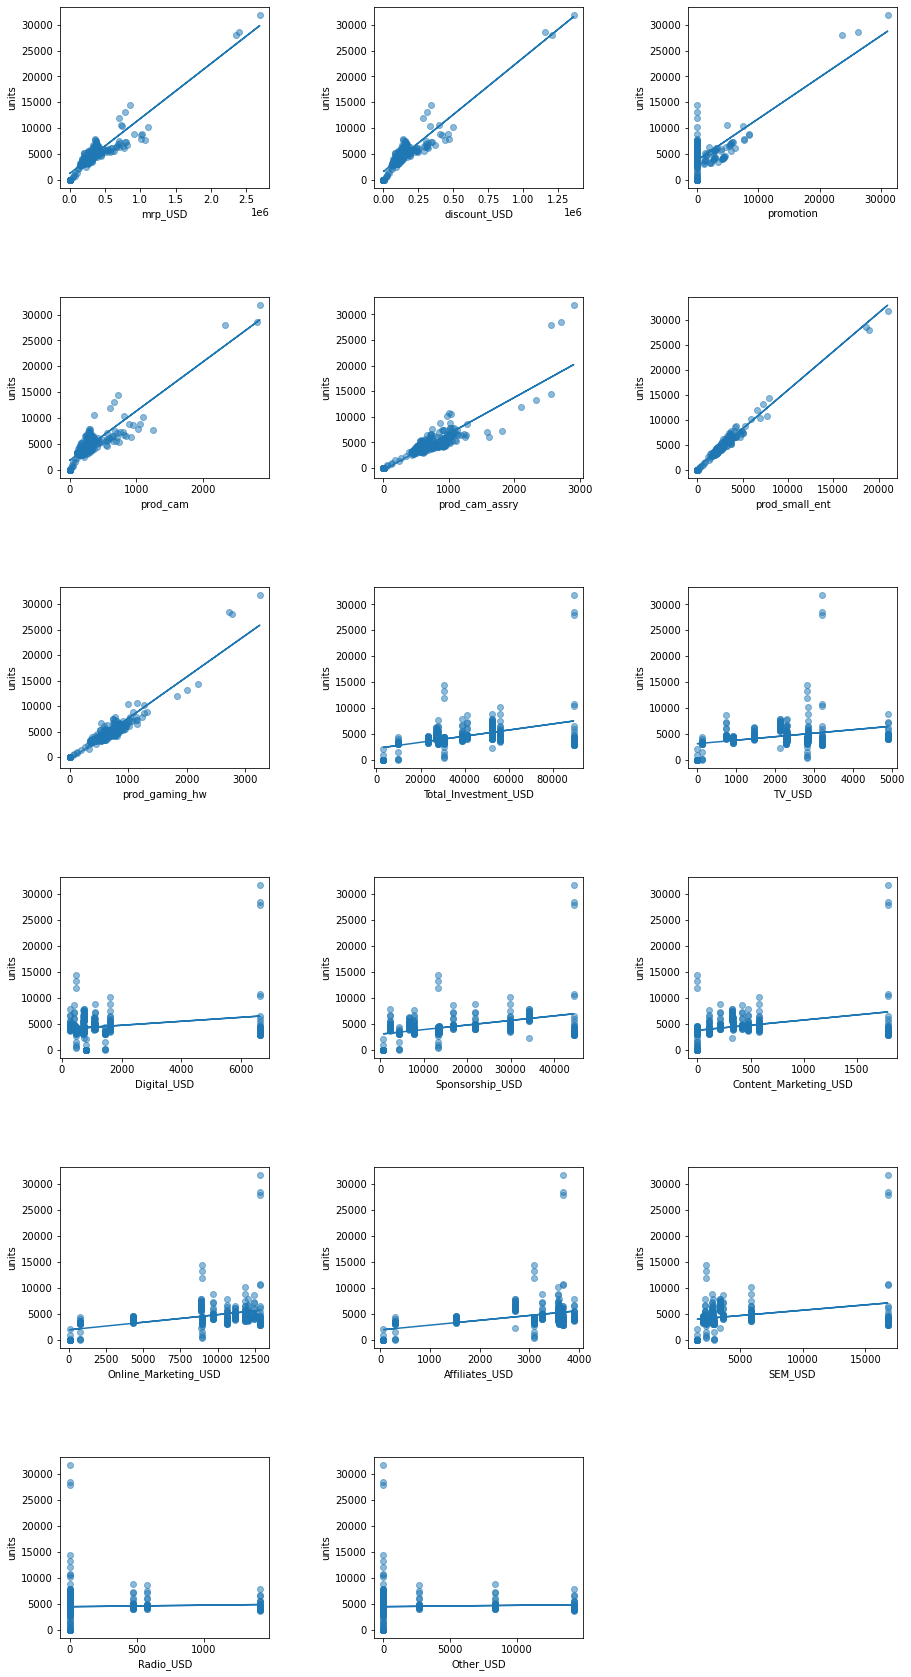

In [190]:
#Create list of features from monthly media channels and promotions
features = sales_media_1.columns.drop(['Date', 'units', 'revenue_USD'])
y_col = 'units'

#Create scatterplots - sales_media_1
scatterplots(features,y_col=y_col,df=sales_media_1, ncol=3)

#### Option 1 Scatter Plot Notes:
As expected, the number of units sold has a strong linear relationship with the baseline/control variables. The number of units sold also has a linear relationship with each of the media spend/incremental variables, but the relationships are weak and there are some large outliers.

#### Option 2

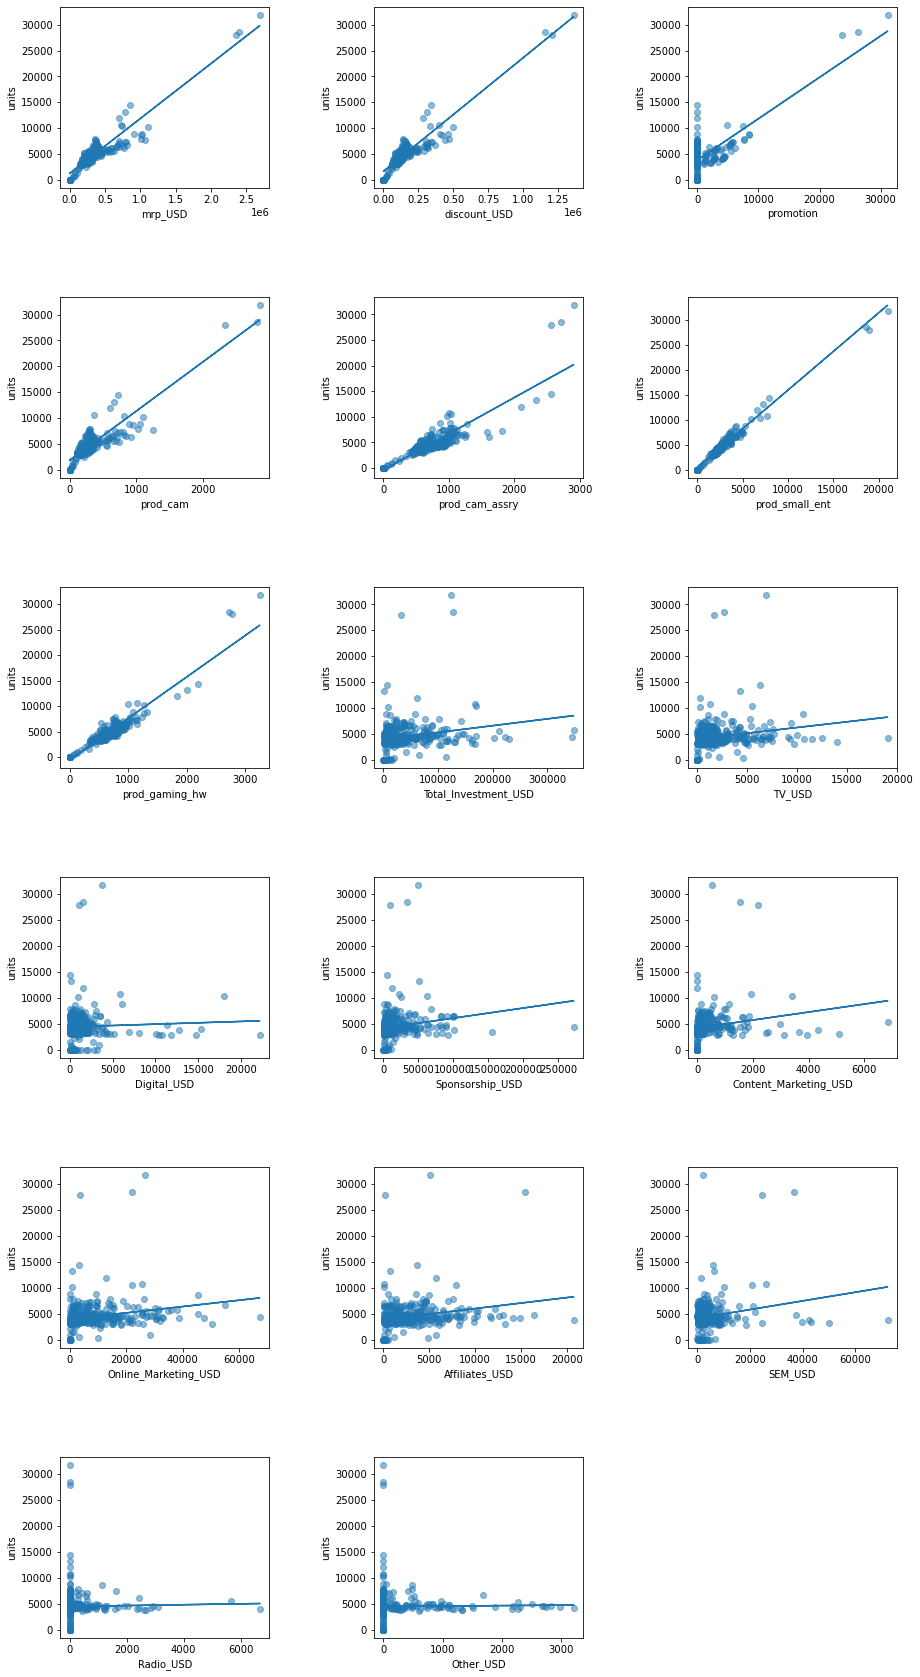

In [192]:
#Create scatterplots - sales_media_2
scatterplots(features,y_col=y_col,df=sales_media_2, ncol=3)

#### Option 2 Scatter Plot Notes:
Similar to option 1, the units sold has a linear relationship with each of the media spend/incremental variables, but b

#### Option 3

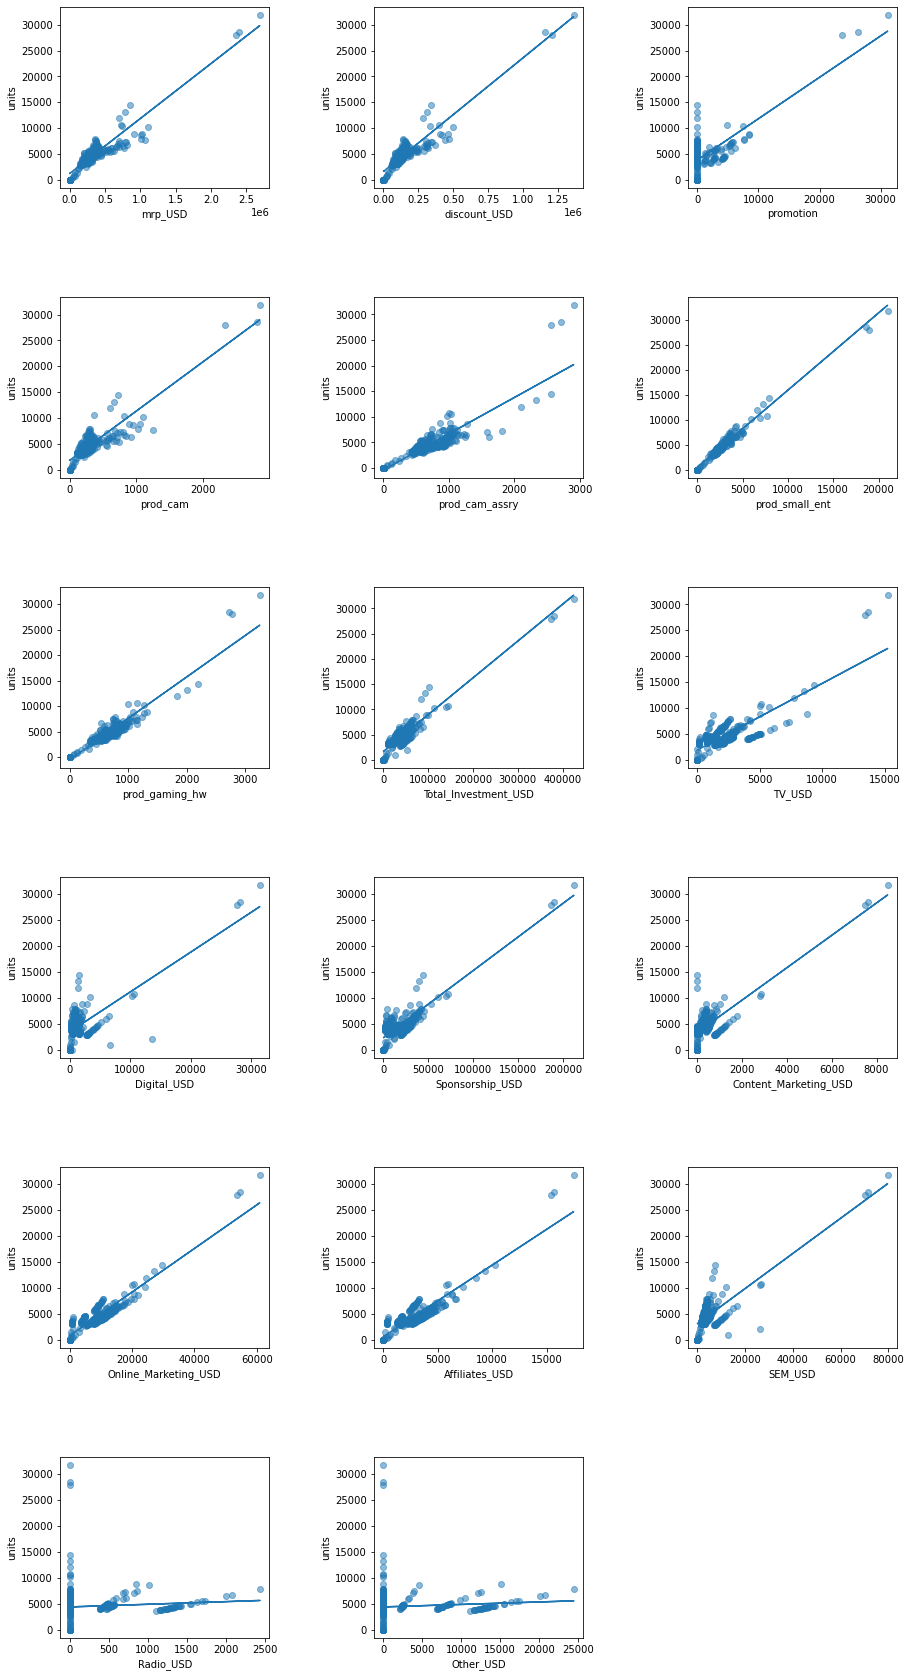

In [195]:
#Create scatterplots - sales_media_3
scatterplots(features,y_col=y_col,df=sales_media_3, ncol=3)

#### Option 3 Scatter Plot Notes:
As expected based on the correlations, option 3 generated very strong linear relationships that likely do not exist. It would not be statistically sound to generate a model using option 3.

## F. Next Steps <a class="anchor" id="f"></a>

* Select DV:
    * In order to control for macroeconomic and other external factors that have a stronger impact on revenue dollars than on the number of units sold, units will be used as dependent variable.
    * Drop revenue_USD from data prior to modeling
* Select data:
    * According to the exploration of relationships, option 1 appears to have generated the most appropriate dataset for modeling.
    * Option 2 had similar results based on the scatterplot, so it might be worth creating models from both and comparing results to select the best model.
    * Option 3 resulted in a likely unrealistic relationship between units sold and media spend, so it is not appropriate to move forward with this dataset.
    * Since seasonality and trends over time were not found in this dataset, the date variable will be dropped from the datasets for modeling.
* Address remaining issues:
    * Multi-collinearity: In both the option 1 and option 2 datasets, several independent variables are highly correlated with one another. A dimension reduction technique should be utilized to address this prior to modeling.
    * Scales: Because some of the independent variables (both baseline and incremental variables) are dollar amounts (with a large variety of sizes) and some are counts of sales, the data needs to be standardized prior to modeling.

#### Save Data

In [198]:
#Save df to pickle.
sales_media_1.drop(columns=['Date','revenue_USD']).to_pickle('../b_Data/sales_media_1.pkl')
sales_media_2.drop(columns=['Date','revenue_USD']).to_pickle('../b_Data/sales_media_2.pkl')